# Банк

## Загрузка данных

In [8]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as snspyenv 
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Download latest version
path = kagglehub.dataset_download("gauravtopre/bank-customer-churn-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/mishnya/.cache/kagglehub/datasets/gauravtopre/bank-customer-churn-dataset/versions/1


In [3]:

if os.path.isdir(path):
    # Найдите CSV-файл в папке
    files = os.listdir(path)
    csv_file = [f for f in files if f.endswith('.csv')][0]  # Берем первый CSV
    full_path = os.path.join(path, csv_file)
else:
    full_path = path  # Если это уже путь к файлу

# Чтение CSV в DataFrame
df = pd.read_csv(full_path)
# styled_df = df.style.set_properties(**{'text-align': 'center'})
# Просмотр первых строк
df.head(8)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1


## Обучение

In [4]:

# Выбираем признаки и целевую переменную
features = ['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
            'products_number', 'active_member', 'estimated_salary']

target = 'churn'

# Разделение на X и y
X = df[features]
y = df[target]


# Определяем категориальные признаки (CatBoost сам их обработает)
categorical_features = ['country', 'gender']

# Проверяем баланс классов
class_counts = y.value_counts()
print("Class distribution:")
print(class_counts)

# Вычисляем веса классов (если данные несбалансированные)
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights_dict)




Class distribution:
churn
0    7963
1    2037
Name: count, dtype: int64
Class Weights: {0: 0.6279040562602034, 1: 2.454590083456063}


In [6]:
# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# X_test, X_oot, Y_test, Y_oot = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Создание и обучение модели с подбором гиперпараметров
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=4,
    cat_features=categorical_features,
    scale_pos_weight=class_weights_dict[1] * 1.2 ,
    verbose= False,
    l2_leaf_reg=6,
)

model.fit(X_train, y_train)

# Предсказания
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Вычисление метрик
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Train F1-score: {train_f1:.4f}, Test F1-score: {test_f1:.4f}")

# Вывод Classification Report без accuracy, macro avg и weighted avg
report = classification_report(y_test, y_test_pred, digits=4, zero_division=0, output_dict=True)

print("\nClassification Report:")
print(f"Class 0 - Precision: F1-score: {report['0']['f1-score']:.2f}, Support: {int(report['0']['support'])}")
print(f"Class 1 - Precision: F1-score: {report['1']['f1-score']:.2f}, Support: {int(report['1']['support'])}")
# print(f"Class 1 - Precision: {report['1']['precision']:.2f}, Recall: {report['1']['recall']:.2f}, F1-score: {report['1']['f1-score']:.2f}, Support: {int(report['1']['support'])}")

Train Accuracy: 0.8386, Test Accuracy: 0.8370
Train F1-score: 0.6441, Test F1-score: 0.6457

Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407


In [7]:
# Предсказания для OOT
y_oot_pred = model.predict(X_oot)

# Вычисление метрик
oot_accuracy = accuracy_score(y_oot, y_oot_pred)
oot_f1 = f1_score(y_oot, y_oot_pred)

print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, OOT Accuracy: {oot_accuracy:.4f}")
print(f"Train F1-score: {train_f1:.4f}, Test F1-score: {test_f1:.4f}, OOT F1-score: {oot_f1:.4f}")



NameError: name 'X_oot' is not defined

In [ ]:

# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test, model.predict(X_test))
# Настраиваем отображение
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
# Подписываем оси на русском
plt.xlabel("Предсказанная метка")
plt.ylabel("Истинная метка")
plt.title("Матрица ошибок")
plt.xticks(ticks=[0.5, 1.5], labels=["Клиент остался", "Клиент ушел"])
plt.yticks(ticks=[0.5, 1.5], labels=["Клиент остался", "Клиент ушел"], rotation=0)

# Показываем график
plt.show()


NameError: name 'sns' is not defined

<Figure size 600x400 with 0 Axes>

Корреляция Мэтьюса

In [9]:

a,b,c,d = 1382,211,113,294
print((a*d - b*c)/(np.sqrt((a+b) * (a+c) * (d+b) * (c+d))))

0.5466638056393128


In [ ]:
importances = model.feature_importances_
print(features)
print(importances)

['credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'products_number', 'active_member', 'estimated_salary']
[ 1.60386487 10.32969859  2.77192427 26.86891162  1.12315028 11.70590331
 35.92960291  7.93632875  1.7306154 ]


In [ ]:

y_oot_pred_proba = model.predict_proba(X_oot)[:, 1]
# Предсказания вероятностей для ROC-кривой
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_oot_pred_proba = model.predict_proba(X_oot)[:, 1]

# ROC-кривые
model_fpr_train, model_tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
model_fpr_test, model_tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
model_fpr_oot, model_tpr_oot, _ = roc_curve(y_oot, y_oot_pred_proba)

# Базовая линия (случайное угадывание)
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])

# Построение графика
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(base_fpr, base_tpr, 'b', label='Baseline')
ax.plot(model_fpr_train, model_tpr_train, 'r--', label='Train')
ax.plot(model_fpr_test, model_tpr_test, 'r', label='Test')
ax.plot(model_fpr_oot, model_tpr_oot, 'g', label='OOT')

ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC AUC SCORE')

plt.show()

NameError: name 'X_oot' is not defined

### Не использую баланс классов

**Параметры модели:**

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.015,
    depth=3,
    cat_features=categorical_features,
    verbose= False,
    l2_leaf_reg=8,
)

**Результаты:**

Train Accuracy: 0.8691, Test Accuracy: 0.8715

Train F1-score: 0.6036, Test F1-score: 0.6088

Classification Report:

Class 0 - Precision: 0.88, Recall: 0.97, F1-score: 0.92, Support: 1593

Class 1 - Precision: 0.80, Recall: 0.49, F1-score: 0.61, Support: 407

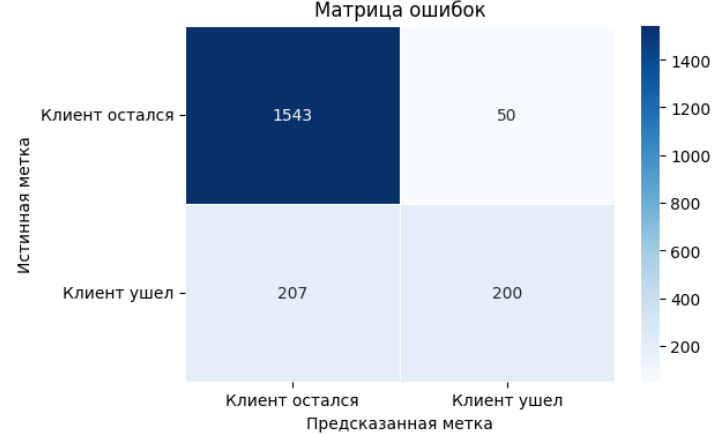

### Использую баланс классов

**Параметры модели:**

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.015,
    depth=3,
    cat_features=categorical_features,
    scale_pos_weight=class_weights_dict[1] * 1.2 ,
    verbose= False,
    l2_leaf_reg=8,
)

**Результаты:**

Train Accuracy: 0.8380, Test Accuracy: 0.8350

Train F1-score: 0.6420, Test F1-score: 0.6382

Classification Report:

Class 0 - Precision: 0.92, Recall: 0.87, F1-score: 0.89, Support: 1593

Class 1 - Precision: 0.58, Recall: 0.71, F1-score: 0.64, Support: 407

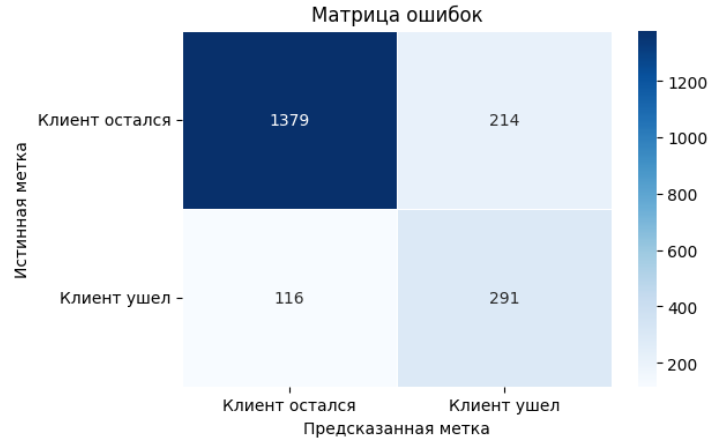

## Перебор параметров

In [15]:
import seaborn as sns
def Mutnes(cd):
  a,b,c,d = cd[0][0],cd[0][0],cd[0][0],cd[0][0]
  print(f'МСС = {(a*d - b*c)/(np.sqrt((a+b) * (a+c) * (d+b) * (c+d)))})')

def matrix_error(cm):

  # Настраиваем отображение
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)

  # Подписываем оси на русском
  plt.xlabel("Предсказанная метка")
  plt.ylabel("Истинная метка")
  plt.title("Матрица ошибок")
  plt.xticks(ticks=[0.5, 1.5], labels=["Клиент ушел", "Клиент остался"])
  plt.yticks(ticks=[0.5, 1.5], labels=["Клиент ушел", "Клиент остался"], rotation=0)

  # Показываем график
  plt.show()


In [9]:

# Выбираем признаки и целевую переменную
features = ['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
            'products_number', 'active_member', 'estimated_salary']
target = 'churn'# Разделение на X и y
X = df[features]
y = df[target]

# Определяем категориальные признаки (CatBoost сам их обработает)
categorical_features = ['country', 'gender']

# Проверяем баланс классов
class_counts = y.value_counts()
print("Class distribution:")
print(class_counts)
# Вычисляем веса классов (если данные несбалансированные)
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights_dict)




Class distribution:
churn
0    7963
1    2037
Name: count, dtype: int64
Class Weights: {0: 0.6279040562602034, 1: 2.454590083456063}


In [18]:

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Создание и обучение модели с подбором гиперпараметров

learning_rate =[0.01,0.02, 0.03, 0.035, 0.04, 0.05,0.06]
for estimator in range(100,201,100):
  print(estimator)
  for depth in range(3,8):
    for learn_rate in learning_rate:
        for multiplier in [1, 1.1, 1.2,1.3]:
          for l2 in range(4,7):

            model = CatBoostClassifier(
                iterations= estimator,
                learning_rate= learn_rate ,
                depth=depth ,
                cat_features=categorical_features,
                scale_pos_weight=class_weights_dict[1] * multiplier ,
                verbose= False,
                l2_leaf_reg=6,
            )

            model.fit(X_train, y_train)

            # Предсказания
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Вычисление метрик
            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)

            train_f1 = f1_score(y_train, y_train_pred)
            test_f1 = f1_score(y_test, y_test_pred)

            cm_matrix = confusion_matrix(y_test, y_test_pred)
            if cm_matrix[1][0] < 115 and cm_matrix[0][1] < 223:
              print(f'Количество деревьев: {estimator}')
              print(f'Глубина деревьева: {depth}')
              print(f'Скорость обучения: {learn_rate}')
              # Вычисление метрик
              train_accuracy = accuracy_score(y_train, y_train_pred)
              test_accuracy = accuracy_score(y_test, y_test_pred)

              train_f1 = f1_score(y_train, y_train_pred)
              test_f1 = f1_score(y_test, y_test_pred)

              print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
              print(f"Train F1-score: {train_f1:.4f}, Test F1-score: {test_f1:.4f}")
              print(multiplier)
              matrix_error(cm_matrix)
              # Вывод Classification Report без accuracy, macro avg и weighted avg
              report = classification_report(y_test, y_test_pred, digits=4, zero_division=0, output_dict=True)
              # Вычисление метрик

              print("\nClassification Report:")
              print(f"Class 0 - Precision: F1-score: {report['0']['f1-score']:.2f}, Support: {int(report['0']['support'])}")
              print(f"Class 1 - Precision: F1-score: {report['1']['f1-score']:.2f}, Support: {int(report['1']['support'])}")
              # print(f"Class 1 - Precision: {report['1']['precision']:.2f}, Recall: {report['1']['recall']:.2f}, F1-score: {report['1']['f1-score']:.2f}, Support: {int(report['1']['support'])}")

100
200


KeyboardInterrupt: 

100
200
Количество деревьев: 200
Глубина деревьева: 4
Скорость обучения: 0.04
Train Accuracy: 0.8371, Test Accuracy: 0.8370
Train F1-score: 0.6406, Test F1-score: 0.6425
1.2


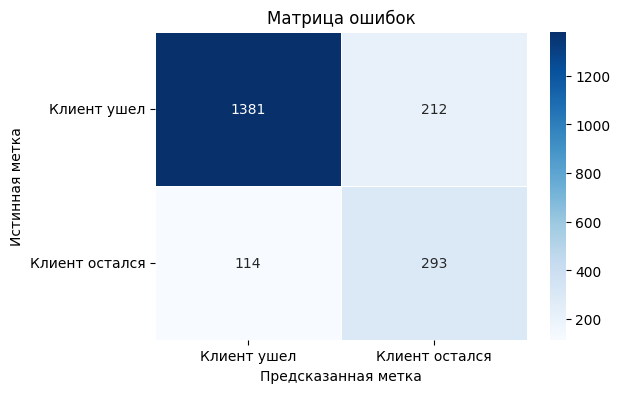


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 4
Скорость обучения: 0.04
Train Accuracy: 0.8371, Test Accuracy: 0.8370
Train F1-score: 0.6406, Test F1-score: 0.6425
1.2


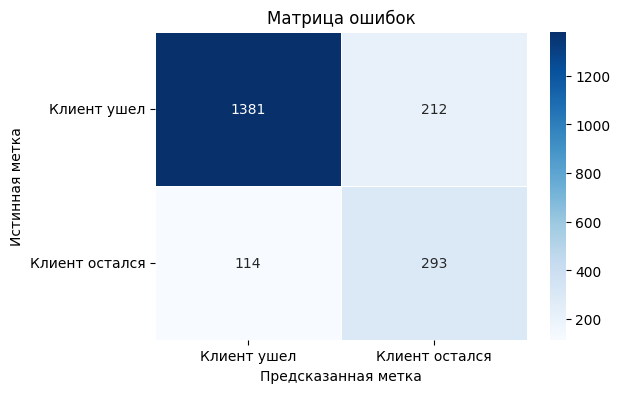


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 4
Скорость обучения: 0.04
Train Accuracy: 0.8371, Test Accuracy: 0.8370
Train F1-score: 0.6406, Test F1-score: 0.6425
1.2


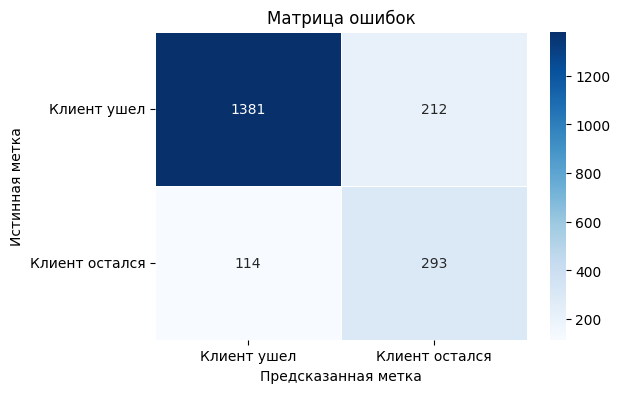


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 4
Скорость обучения: 0.06
Train Accuracy: 0.8420, Test Accuracy: 0.8345
Train F1-score: 0.6508, Test F1-score: 0.6406
1.2


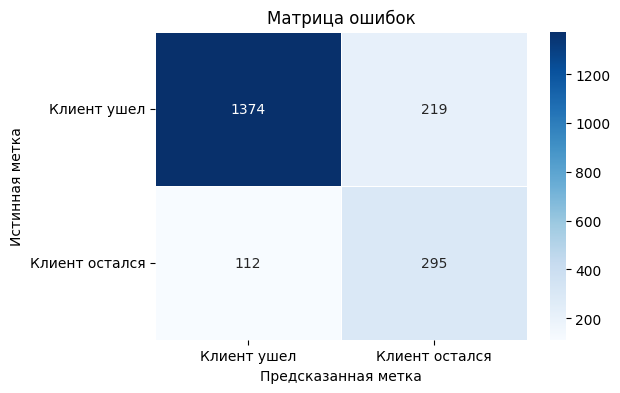


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 4
Скорость обучения: 0.06
Train Accuracy: 0.8420, Test Accuracy: 0.8345
Train F1-score: 0.6508, Test F1-score: 0.6406
1.2


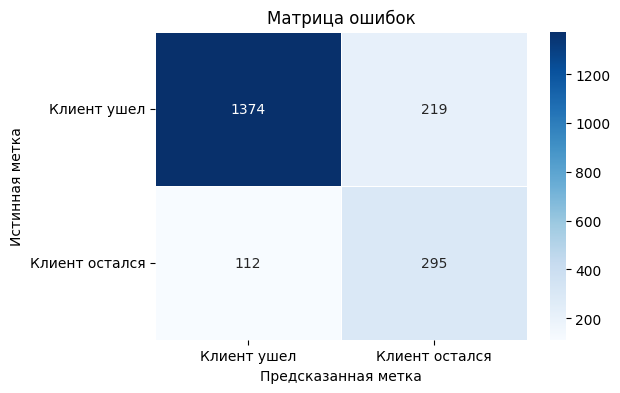


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 4
Скорость обучения: 0.06
Train Accuracy: 0.8420, Test Accuracy: 0.8345
Train F1-score: 0.6508, Test F1-score: 0.6406
1.2


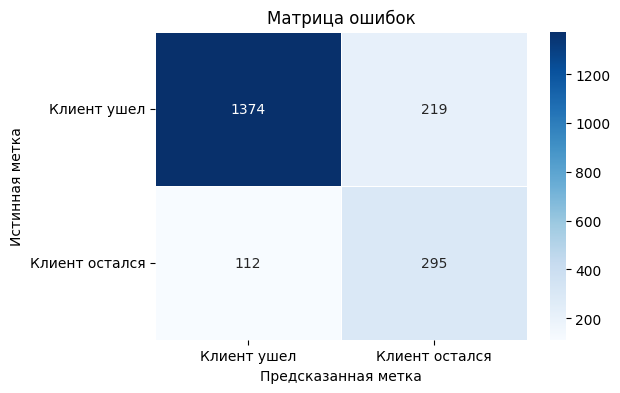


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 5
Скорость обучения: 0.05
Train Accuracy: 0.8433, Test Accuracy: 0.8405
Train F1-score: 0.6551, Test F1-score: 0.6506
1.2


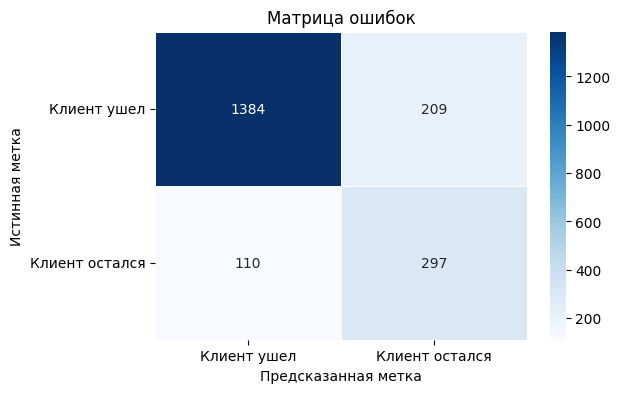


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 200
Глубина деревьева: 5
Скорость обучения: 0.05
Train Accuracy: 0.8433, Test Accuracy: 0.8405
Train F1-score: 0.6551, Test F1-score: 0.6506
1.2


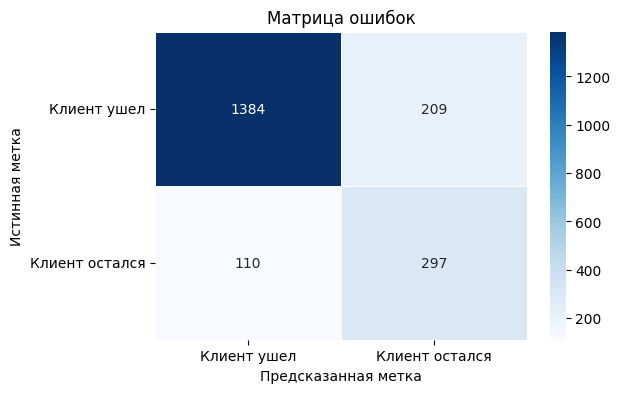


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 200
Глубина деревьева: 5
Скорость обучения: 0.05
Train Accuracy: 0.8433, Test Accuracy: 0.8405
Train F1-score: 0.6551, Test F1-score: 0.6506
1.2


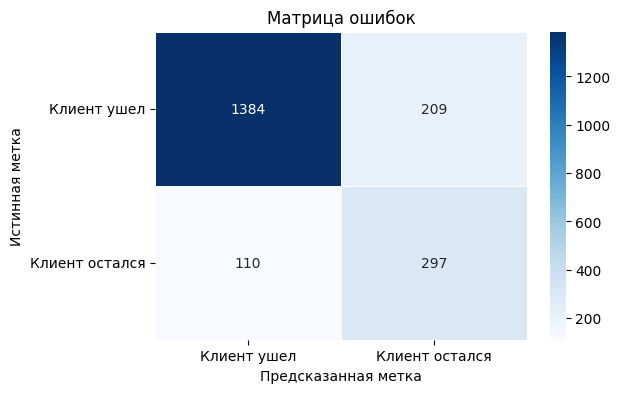


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 200
Глубина деревьева: 5
Скорость обучения: 0.06
Train Accuracy: 0.8470, Test Accuracy: 0.8350
Train F1-score: 0.6628, Test F1-score: 0.6397
1.2


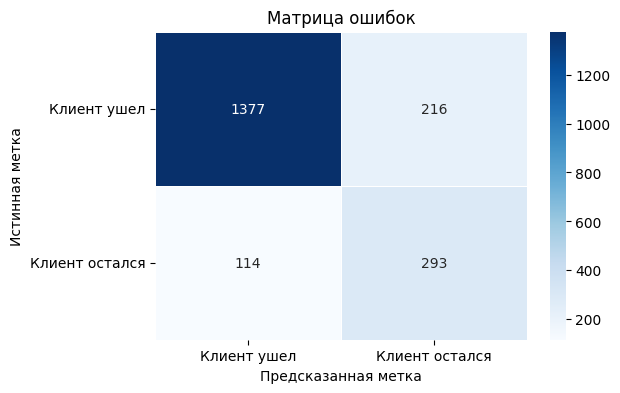


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 5
Скорость обучения: 0.06
Train Accuracy: 0.8470, Test Accuracy: 0.8350
Train F1-score: 0.6628, Test F1-score: 0.6397
1.2


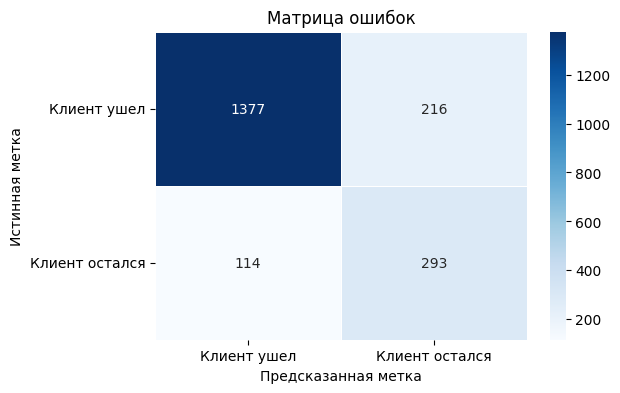


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 5
Скорость обучения: 0.06
Train Accuracy: 0.8470, Test Accuracy: 0.8350
Train F1-score: 0.6628, Test F1-score: 0.6397
1.2


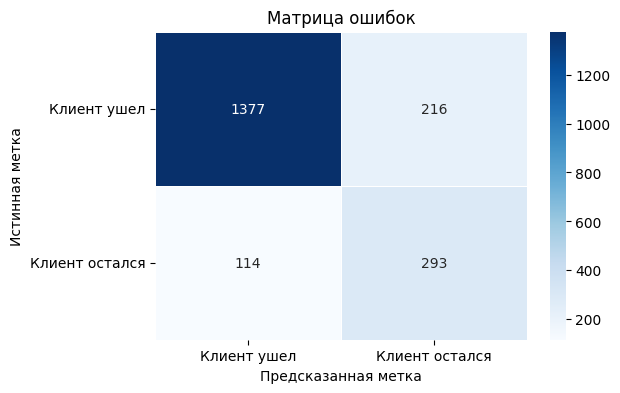


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 6
Скорость обучения: 0.035
Train Accuracy: 0.8436, Test Accuracy: 0.8340
Train F1-score: 0.6545, Test F1-score: 0.6383
1.2


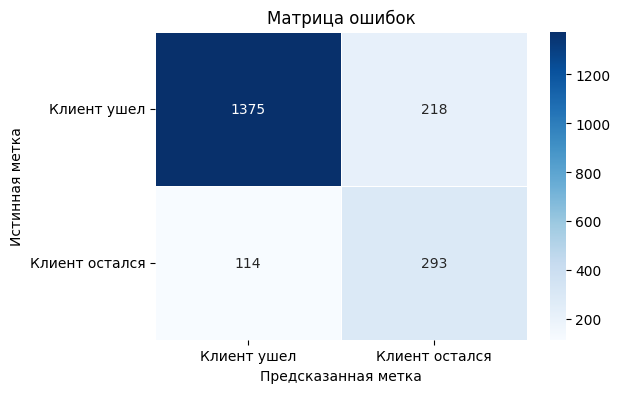


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 6
Скорость обучения: 0.035
Train Accuracy: 0.8436, Test Accuracy: 0.8340
Train F1-score: 0.6545, Test F1-score: 0.6383
1.2


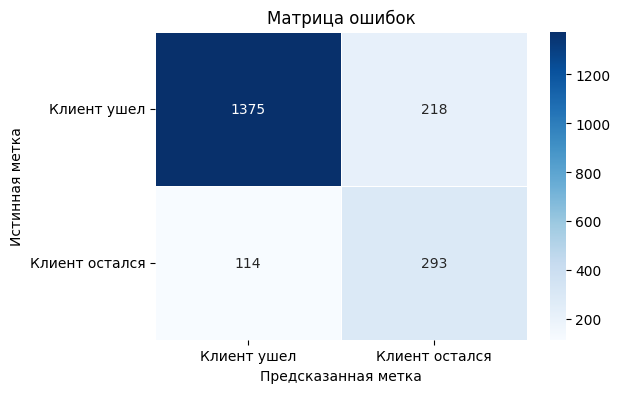


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 6
Скорость обучения: 0.035
Train Accuracy: 0.8436, Test Accuracy: 0.8340
Train F1-score: 0.6545, Test F1-score: 0.6383
1.2


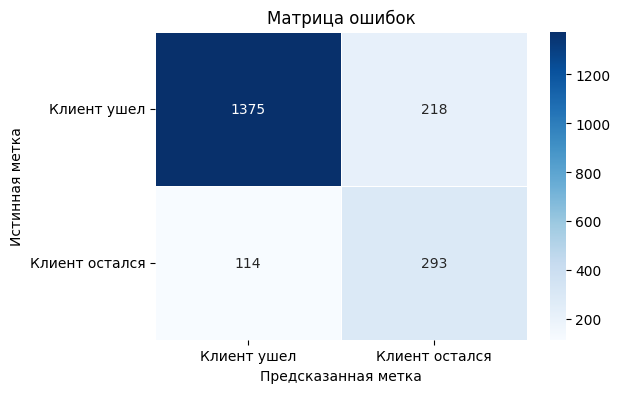


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 6
Скорость обучения: 0.05
Train Accuracy: 0.8499, Test Accuracy: 0.8360
Train F1-score: 0.6669, Test F1-score: 0.6411
1.2


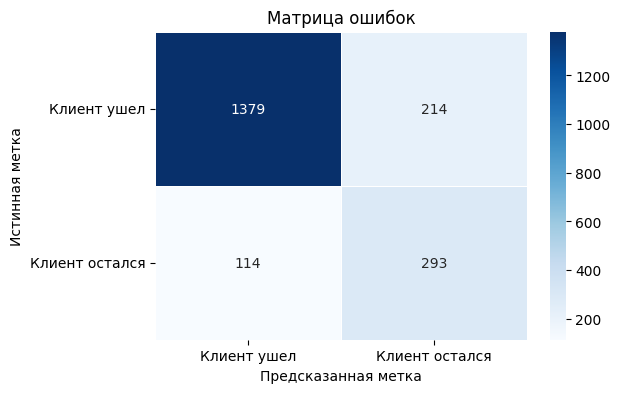


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 6
Скорость обучения: 0.05
Train Accuracy: 0.8499, Test Accuracy: 0.8360
Train F1-score: 0.6669, Test F1-score: 0.6411
1.2


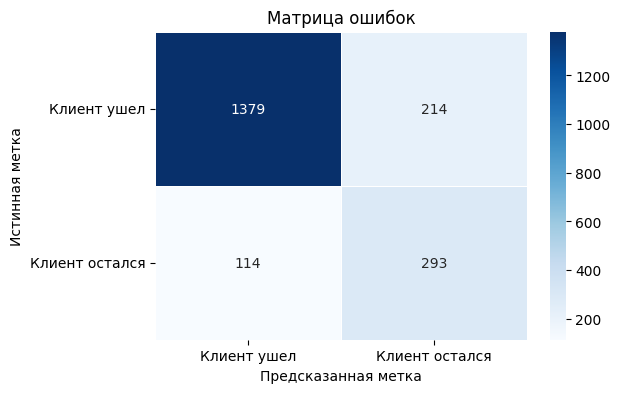


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 6
Скорость обучения: 0.05
Train Accuracy: 0.8499, Test Accuracy: 0.8360
Train F1-score: 0.6669, Test F1-score: 0.6411
1.2


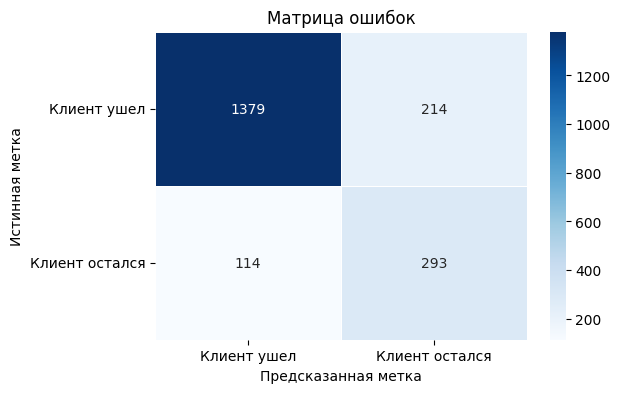


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 7
Скорость обучения: 0.03
Train Accuracy: 0.8491, Test Accuracy: 0.8365
Train F1-score: 0.6654, Test F1-score: 0.6418
1.2


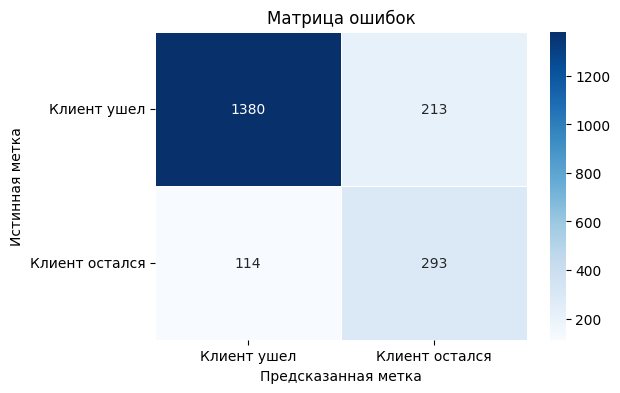


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 7
Скорость обучения: 0.03
Train Accuracy: 0.8491, Test Accuracy: 0.8365
Train F1-score: 0.6654, Test F1-score: 0.6418
1.2


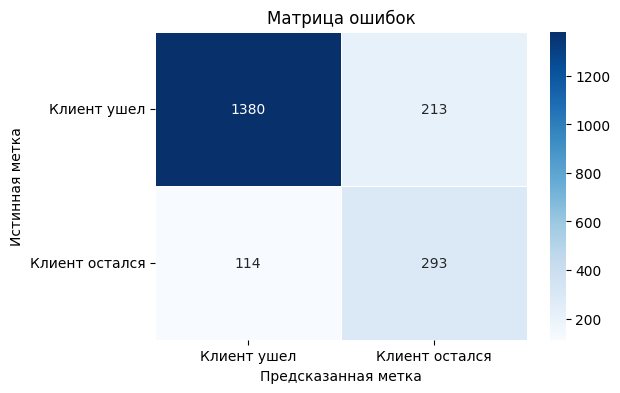


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 200
Глубина деревьева: 7
Скорость обучения: 0.03
Train Accuracy: 0.8491, Test Accuracy: 0.8365
Train F1-score: 0.6654, Test F1-score: 0.6418
1.2


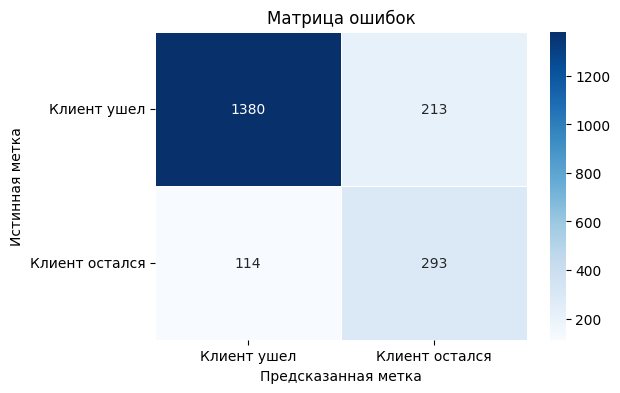


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
300
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.035
Train Accuracy: 0.8395, Test Accuracy: 0.8350
Train F1-score: 0.6459, Test F1-score: 0.6436
1.2


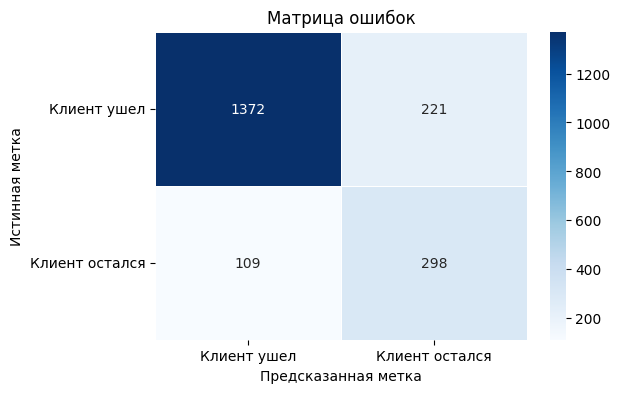


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.035
Train Accuracy: 0.8395, Test Accuracy: 0.8350
Train F1-score: 0.6459, Test F1-score: 0.6436
1.2


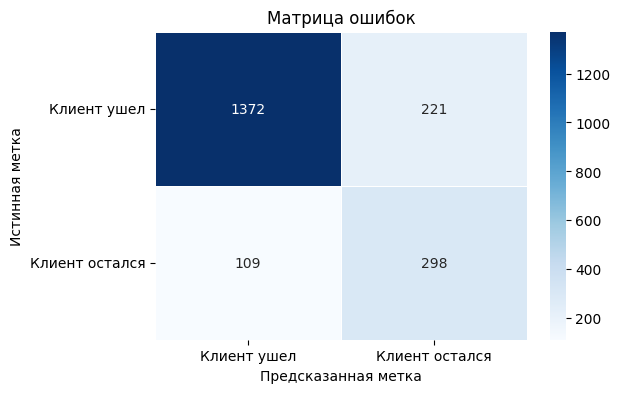


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.035
Train Accuracy: 0.8395, Test Accuracy: 0.8350
Train F1-score: 0.6459, Test F1-score: 0.6436
1.2


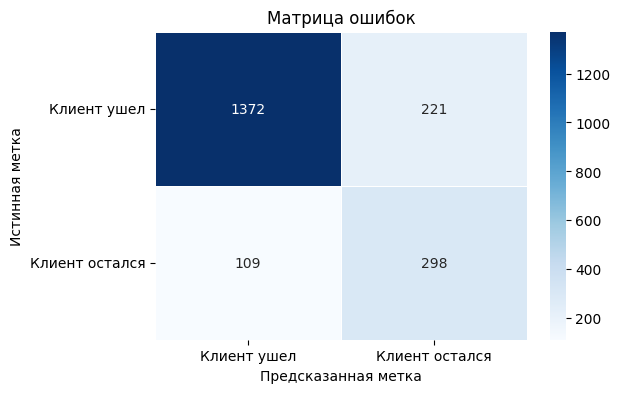


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.04
Train Accuracy: 0.8419, Test Accuracy: 0.8370
Train F1-score: 0.6516, Test F1-score: 0.6457
1.2


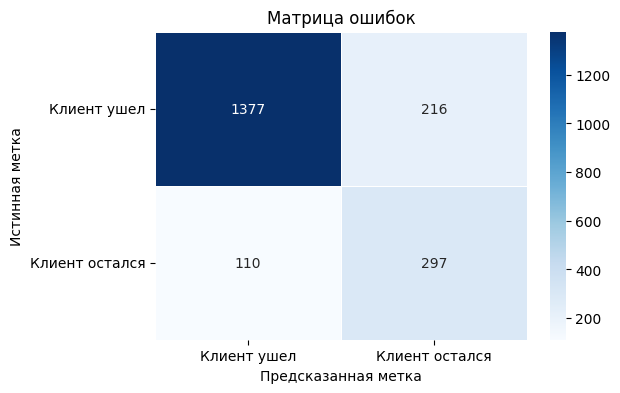


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.04
Train Accuracy: 0.8419, Test Accuracy: 0.8370
Train F1-score: 0.6516, Test F1-score: 0.6457
1.2


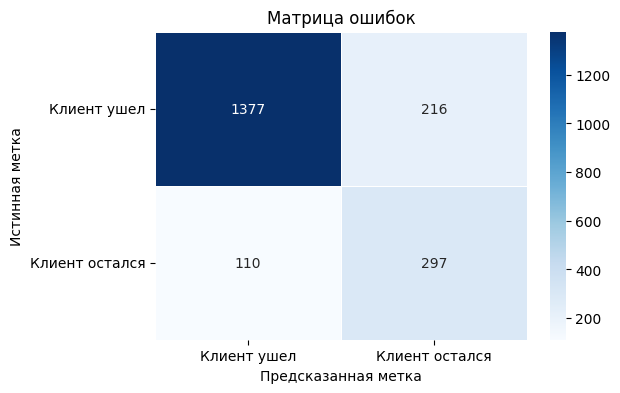


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.04
Train Accuracy: 0.8419, Test Accuracy: 0.8370
Train F1-score: 0.6516, Test F1-score: 0.6457
1.2


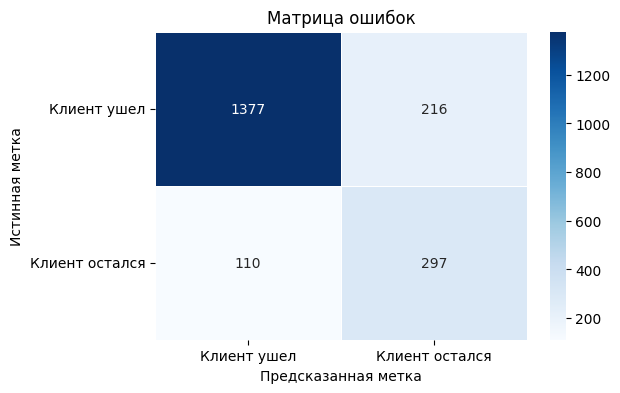


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.05
Train Accuracy: 0.8452, Test Accuracy: 0.8350
Train F1-score: 0.6580, Test F1-score: 0.6413
1.2


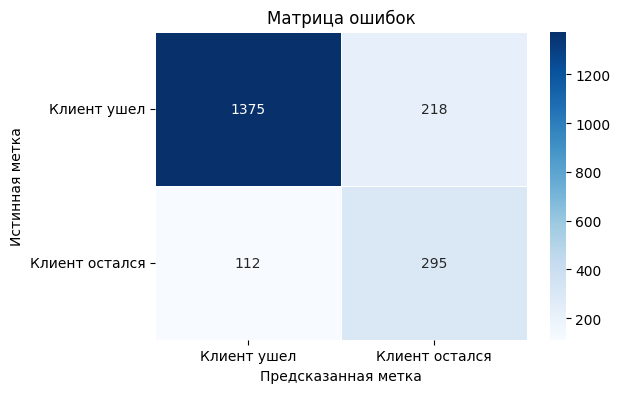


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.05
Train Accuracy: 0.8452, Test Accuracy: 0.8350
Train F1-score: 0.6580, Test F1-score: 0.6413
1.2


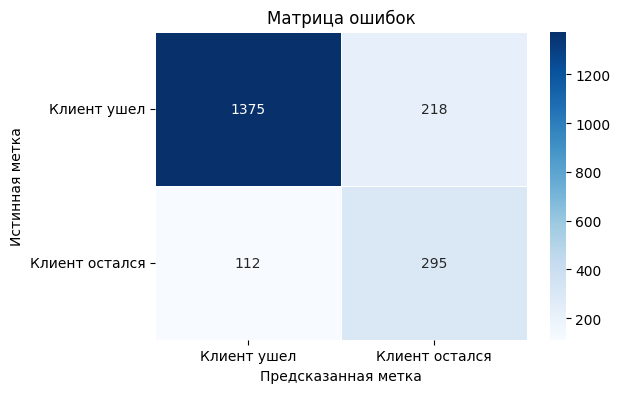


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.05
Train Accuracy: 0.8452, Test Accuracy: 0.8350
Train F1-score: 0.6580, Test F1-score: 0.6413
1.2


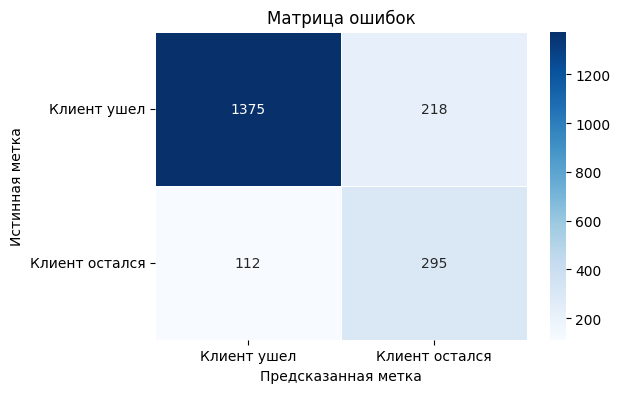


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.06
Train Accuracy: 0.8488, Test Accuracy: 0.8340
Train F1-score: 0.6663, Test F1-score: 0.6391
1.2


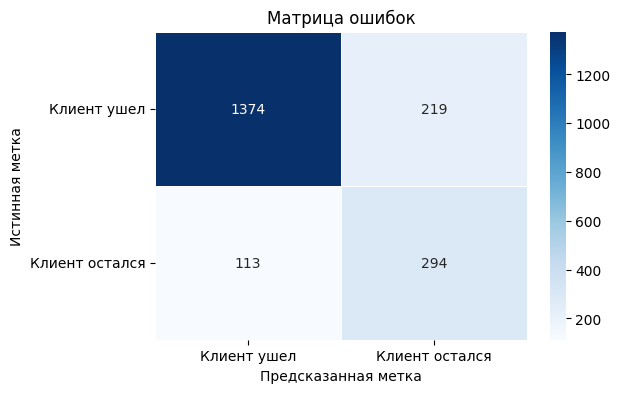


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.06
Train Accuracy: 0.8488, Test Accuracy: 0.8340
Train F1-score: 0.6663, Test F1-score: 0.6391
1.2


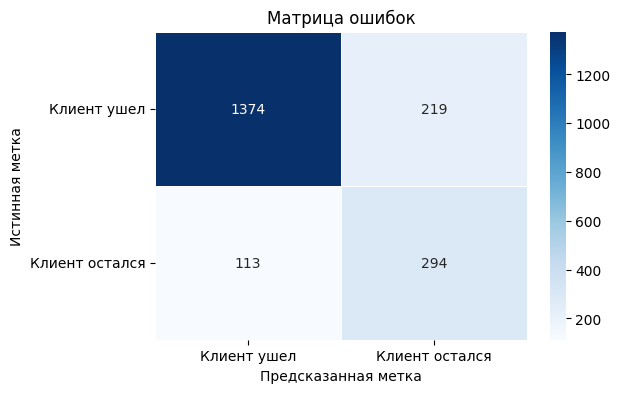


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 4
Скорость обучения: 0.06
Train Accuracy: 0.8488, Test Accuracy: 0.8340
Train F1-score: 0.6663, Test F1-score: 0.6391
1.2


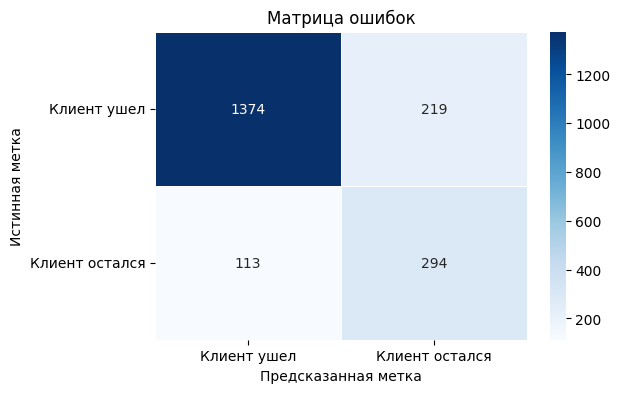


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 5
Скорость обучения: 0.035
Train Accuracy: 0.8455, Test Accuracy: 0.8345
Train F1-score: 0.6572, Test F1-score: 0.6398
1.2


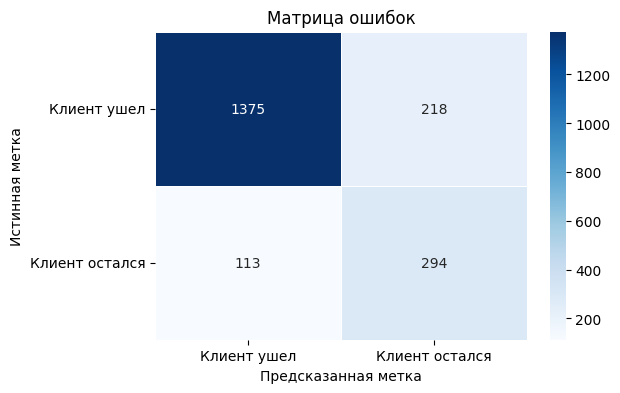


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 5
Скорость обучения: 0.035
Train Accuracy: 0.8455, Test Accuracy: 0.8345
Train F1-score: 0.6572, Test F1-score: 0.6398
1.2


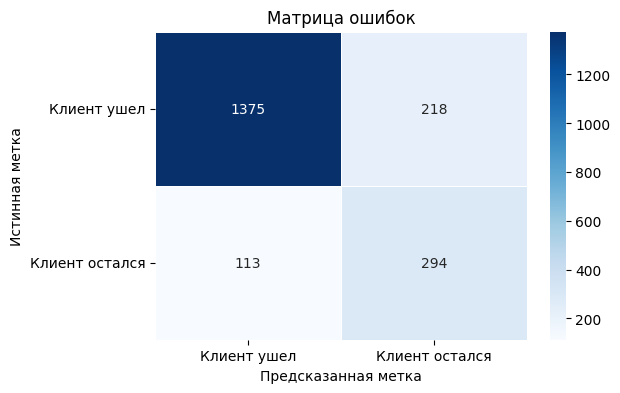


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 5
Скорость обучения: 0.035
Train Accuracy: 0.8455, Test Accuracy: 0.8345
Train F1-score: 0.6572, Test F1-score: 0.6398
1.2


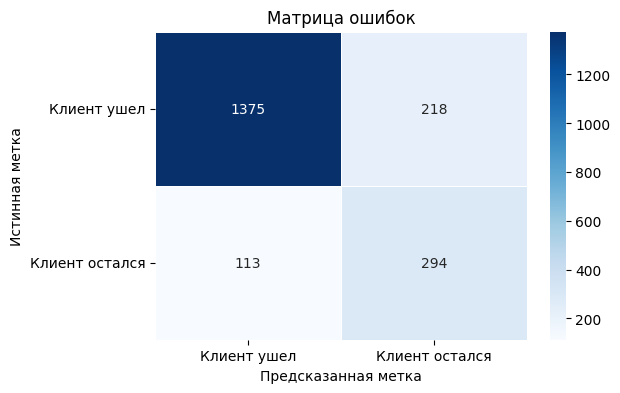


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 6
Скорость обучения: 0.03
Train Accuracy: 0.8468, Test Accuracy: 0.8360
Train F1-score: 0.6619, Test F1-score: 0.6427
1.2


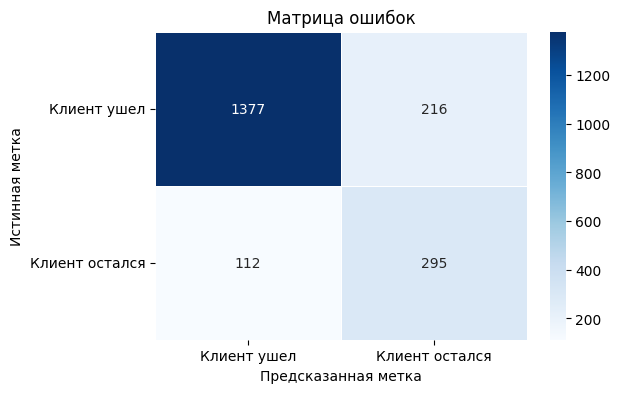


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 6
Скорость обучения: 0.03
Train Accuracy: 0.8468, Test Accuracy: 0.8360
Train F1-score: 0.6619, Test F1-score: 0.6427
1.2


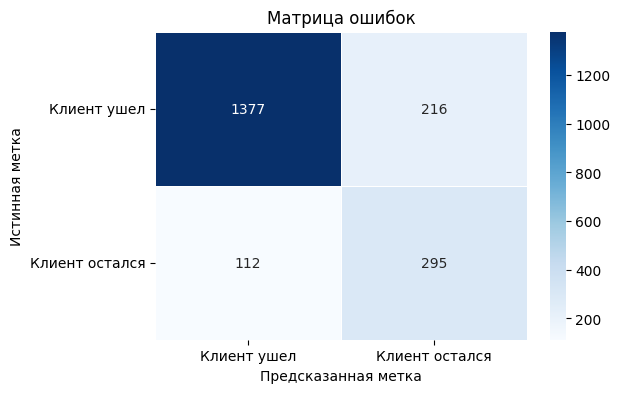


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 6
Скорость обучения: 0.03
Train Accuracy: 0.8468, Test Accuracy: 0.8360
Train F1-score: 0.6619, Test F1-score: 0.6427
1.2


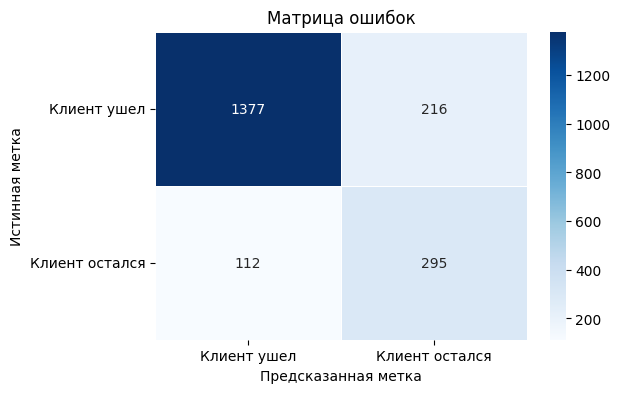


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 6
Скорость обучения: 0.035
Train Accuracy: 0.8482, Test Accuracy: 0.8375
Train F1-score: 0.6650, Test F1-score: 0.6432
1.2


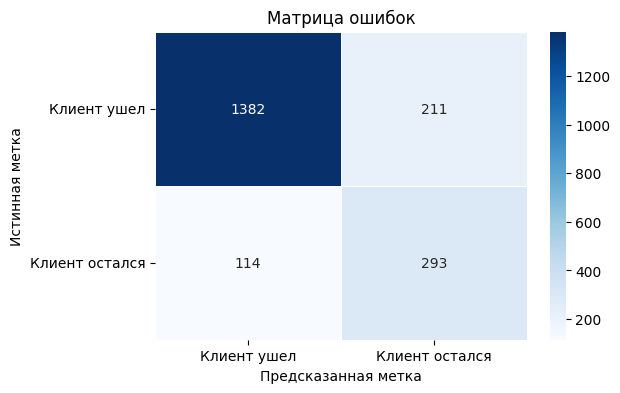


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 6
Скорость обучения: 0.035
Train Accuracy: 0.8482, Test Accuracy: 0.8375
Train F1-score: 0.6650, Test F1-score: 0.6432
1.2


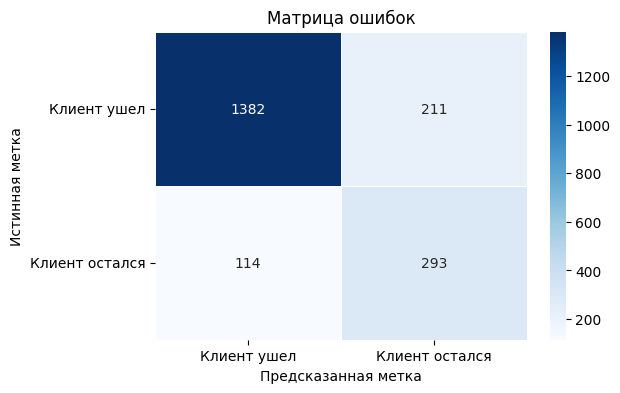


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 6
Скорость обучения: 0.035
Train Accuracy: 0.8482, Test Accuracy: 0.8375
Train F1-score: 0.6650, Test F1-score: 0.6432
1.2


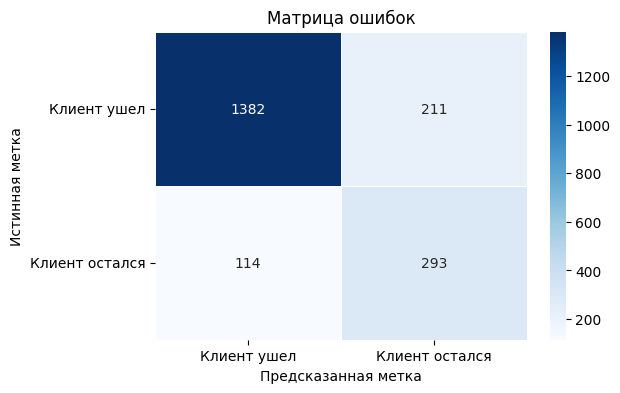


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 6
Скорость обучения: 0.05
Train Accuracy: 0.8611, Test Accuracy: 0.8360
Train F1-score: 0.6925, Test F1-score: 0.6411
1.2


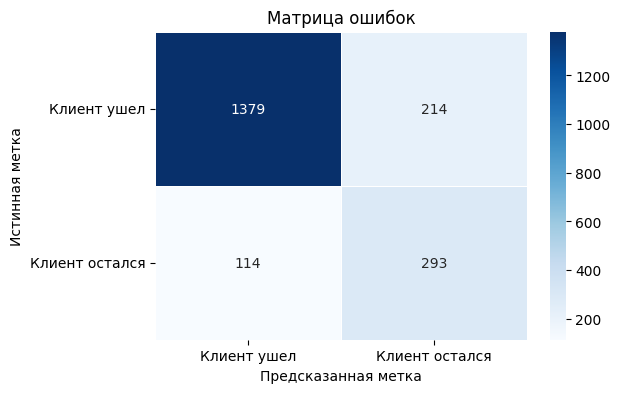


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 6
Скорость обучения: 0.05
Train Accuracy: 0.8611, Test Accuracy: 0.8360
Train F1-score: 0.6925, Test F1-score: 0.6411
1.2


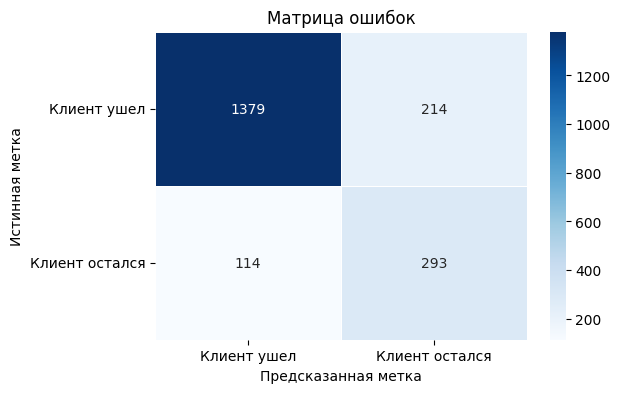


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 300
Глубина деревьева: 6
Скорость обучения: 0.05
Train Accuracy: 0.8611, Test Accuracy: 0.8360
Train F1-score: 0.6925, Test F1-score: 0.6411
1.2


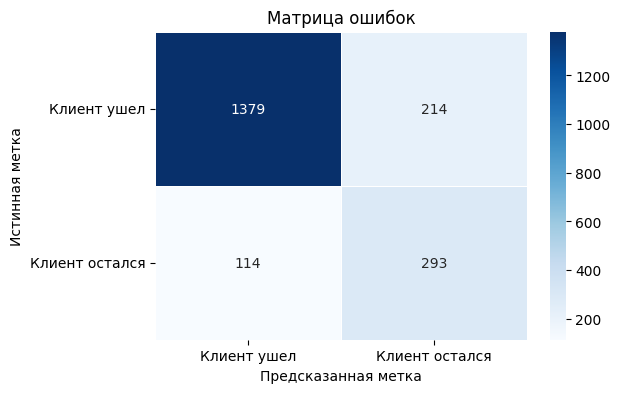


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
400
Количество деревьев: 400
Глубина деревьева: 3
Скорость обучения: 0.04
Train Accuracy: 0.8403, Test Accuracy: 0.8380
Train F1-score: 0.6452, Test F1-score: 0.6440
1.2


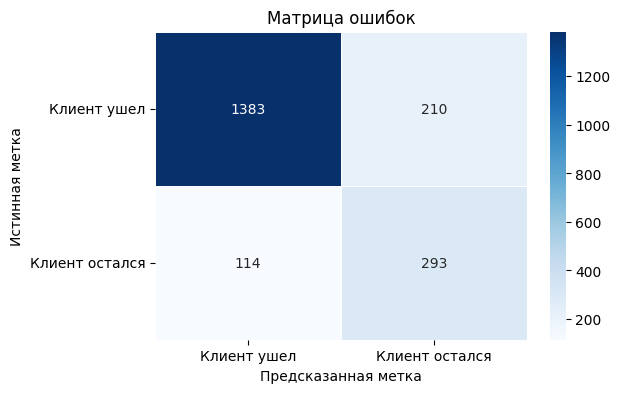


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 3
Скорость обучения: 0.04
Train Accuracy: 0.8403, Test Accuracy: 0.8380
Train F1-score: 0.6452, Test F1-score: 0.6440
1.2


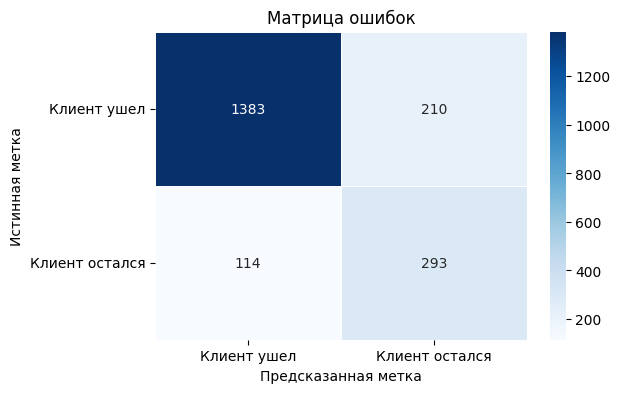


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 3
Скорость обучения: 0.04
Train Accuracy: 0.8403, Test Accuracy: 0.8380
Train F1-score: 0.6452, Test F1-score: 0.6440
1.2


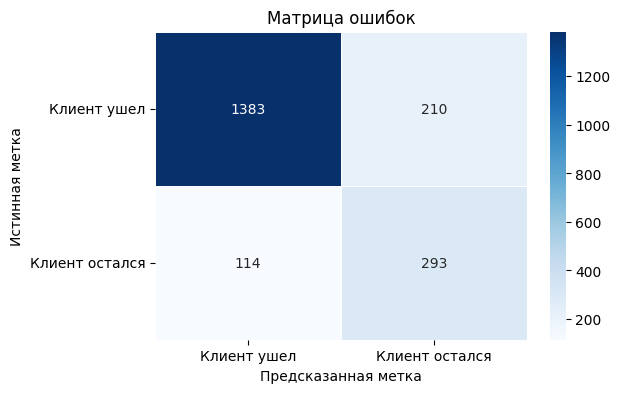


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 4
Скорость обучения: 0.03
Train Accuracy: 0.8424, Test Accuracy: 0.8415
Train F1-score: 0.6508, Test F1-score: 0.6520
1.2


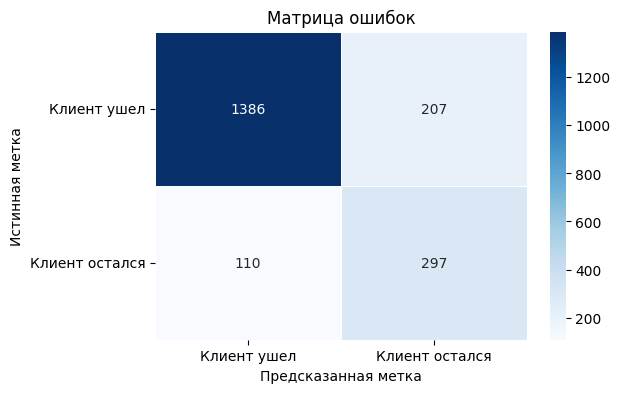


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 400
Глубина деревьева: 4
Скорость обучения: 0.03
Train Accuracy: 0.8424, Test Accuracy: 0.8415
Train F1-score: 0.6508, Test F1-score: 0.6520
1.2


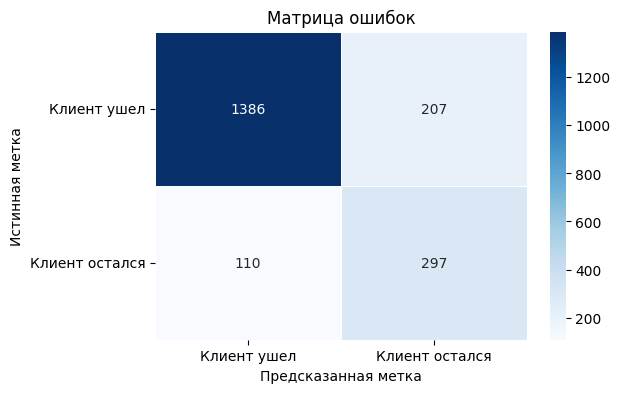


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 400
Глубина деревьева: 4
Скорость обучения: 0.03
Train Accuracy: 0.8424, Test Accuracy: 0.8415
Train F1-score: 0.6508, Test F1-score: 0.6520
1.2


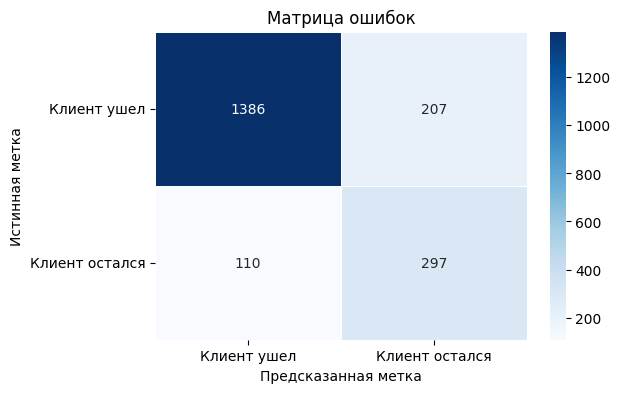


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 400
Глубина деревьева: 4
Скорость обучения: 0.035
Train Accuracy: 0.8450, Test Accuracy: 0.8350
Train F1-score: 0.6559, Test F1-score: 0.6405
1.2


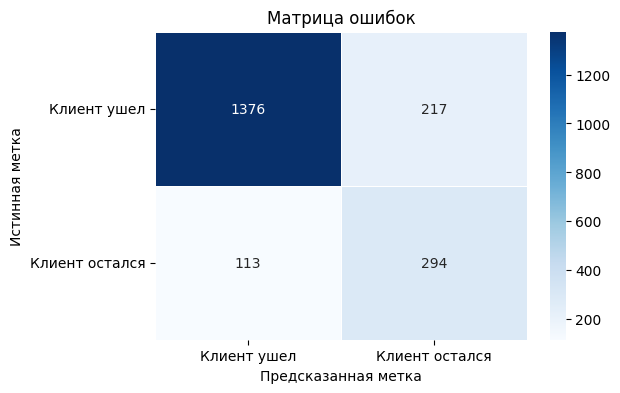


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 4
Скорость обучения: 0.035
Train Accuracy: 0.8450, Test Accuracy: 0.8350
Train F1-score: 0.6559, Test F1-score: 0.6405
1.2


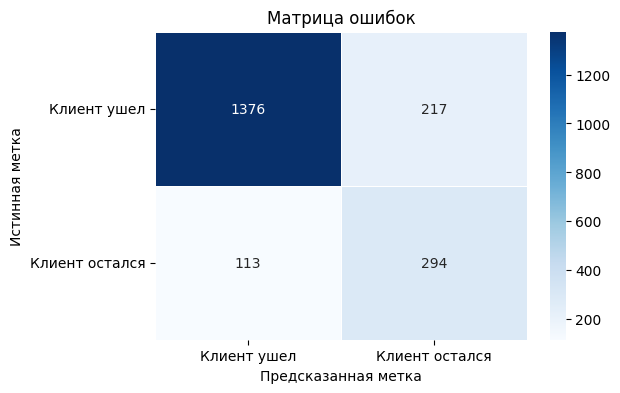


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 4
Скорость обучения: 0.035
Train Accuracy: 0.8450, Test Accuracy: 0.8350
Train F1-score: 0.6559, Test F1-score: 0.6405
1.2


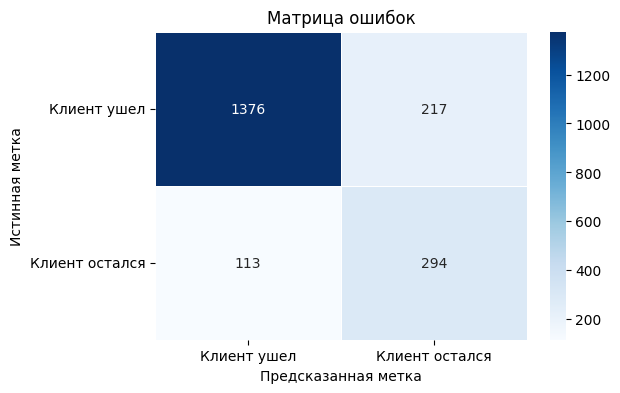


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 5
Скорость обучения: 0.03
Train Accuracy: 0.8461, Test Accuracy: 0.8365
Train F1-score: 0.6600, Test F1-score: 0.6426
1.2


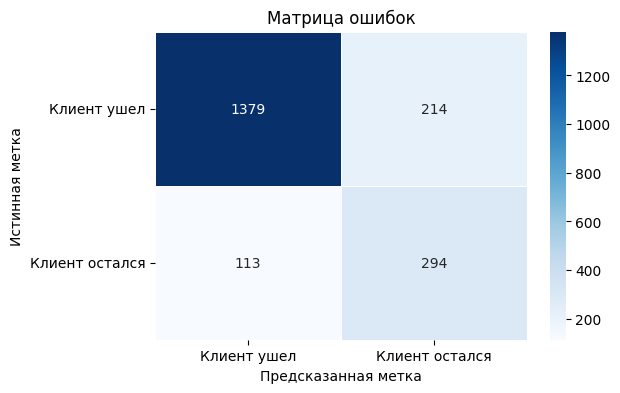


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 5
Скорость обучения: 0.03
Train Accuracy: 0.8461, Test Accuracy: 0.8365
Train F1-score: 0.6600, Test F1-score: 0.6426
1.2


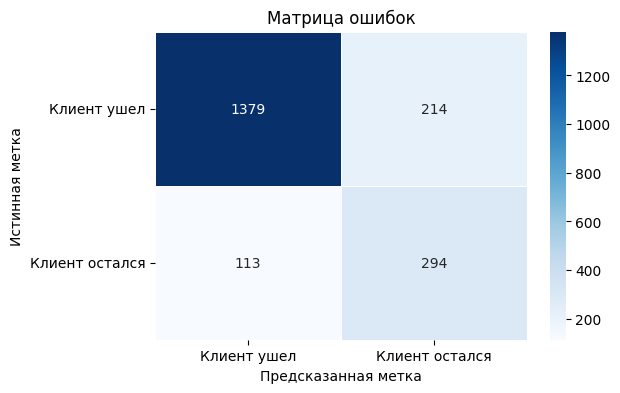


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 5
Скорость обучения: 0.03
Train Accuracy: 0.8461, Test Accuracy: 0.8365
Train F1-score: 0.6600, Test F1-score: 0.6426
1.2


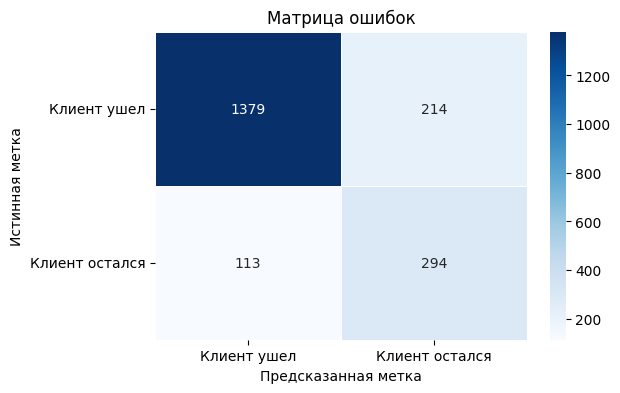


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 5
Скорость обучения: 0.035
Train Accuracy: 0.8521, Test Accuracy: 0.8355
Train F1-score: 0.6709, Test F1-score: 0.6404
1.2


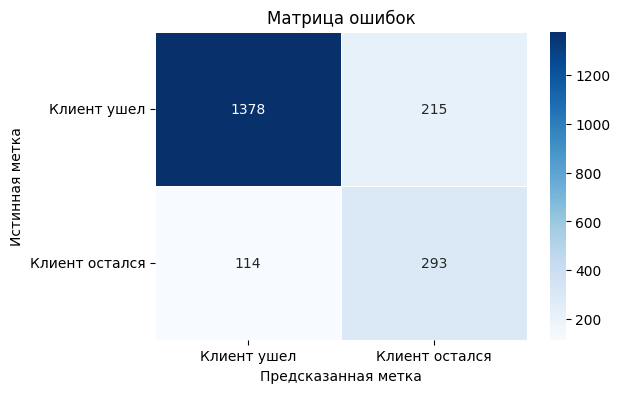


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 5
Скорость обучения: 0.035
Train Accuracy: 0.8521, Test Accuracy: 0.8355
Train F1-score: 0.6709, Test F1-score: 0.6404
1.2


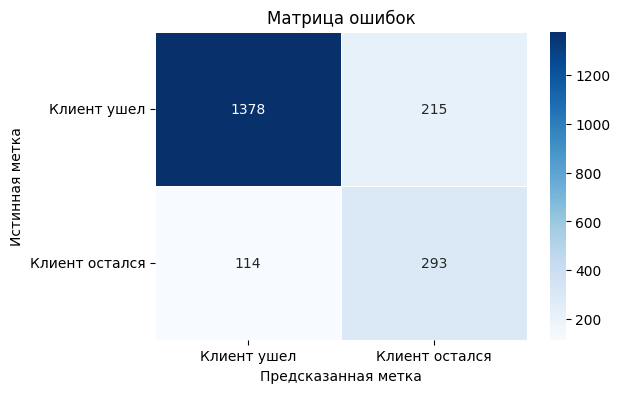


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 5
Скорость обучения: 0.035
Train Accuracy: 0.8521, Test Accuracy: 0.8355
Train F1-score: 0.6709, Test F1-score: 0.6404
1.2


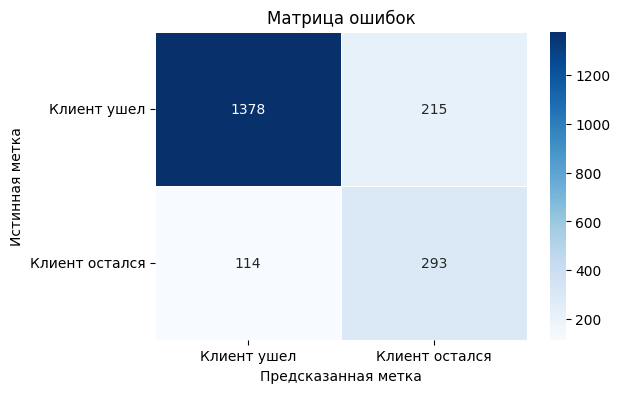


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 5
Скорость обучения: 0.04
Train Accuracy: 0.8551, Test Accuracy: 0.8370
Train F1-score: 0.6772, Test F1-score: 0.6425
1.2


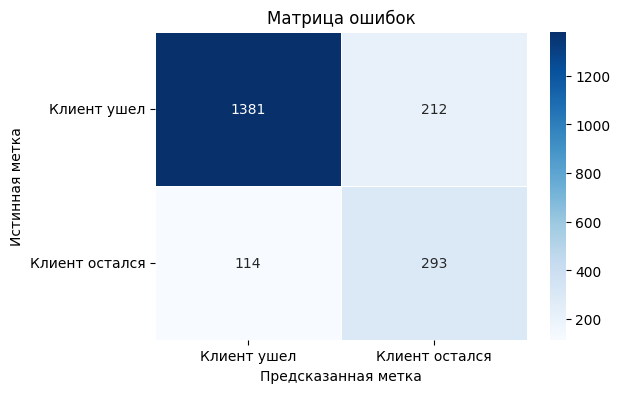


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 5
Скорость обучения: 0.04
Train Accuracy: 0.8551, Test Accuracy: 0.8370
Train F1-score: 0.6772, Test F1-score: 0.6425
1.2


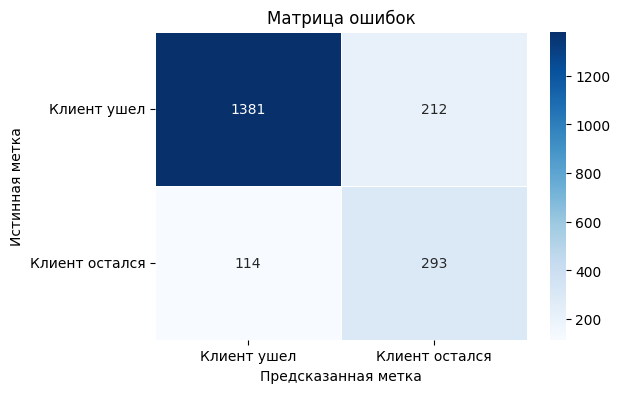


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 400
Глубина деревьева: 5
Скорость обучения: 0.04
Train Accuracy: 0.8551, Test Accuracy: 0.8370
Train F1-score: 0.6772, Test F1-score: 0.6425
1.2


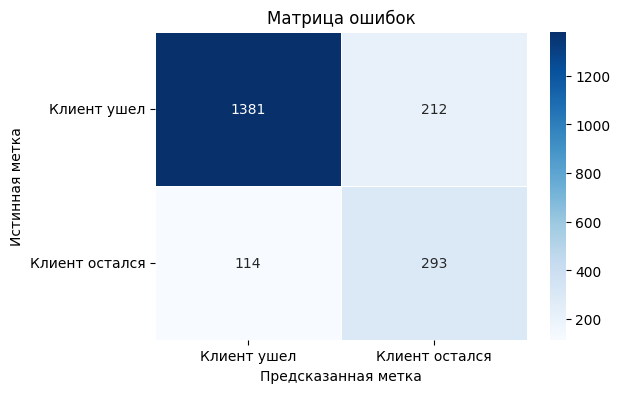


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
500
Количество деревьев: 500
Глубина деревьева: 3
Скорость обучения: 0.03
Train Accuracy: 0.8390, Test Accuracy: 0.8370
Train F1-score: 0.6434, Test F1-score: 0.6425
1.2


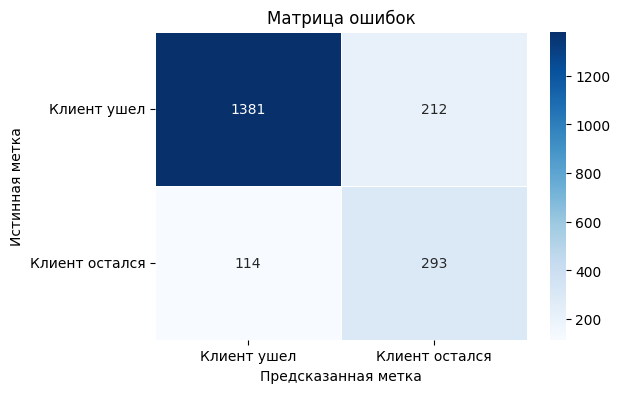


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 3
Скорость обучения: 0.03
Train Accuracy: 0.8390, Test Accuracy: 0.8370
Train F1-score: 0.6434, Test F1-score: 0.6425
1.2


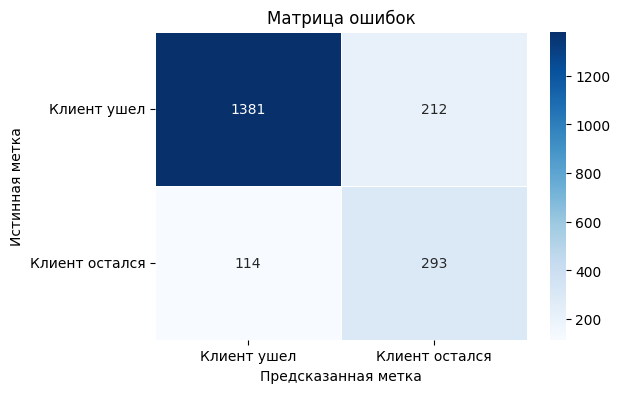


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 3
Скорость обучения: 0.03
Train Accuracy: 0.8390, Test Accuracy: 0.8370
Train F1-score: 0.6434, Test F1-score: 0.6425
1.2


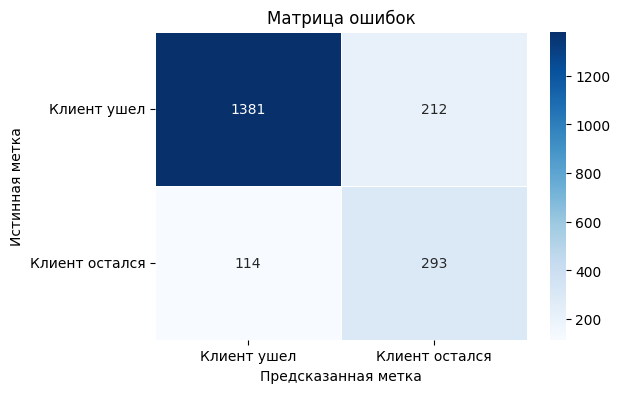


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 4
Скорость обучения: 0.02
Train Accuracy: 0.8403, Test Accuracy: 0.8385
Train F1-score: 0.6477, Test F1-score: 0.6462
1.2


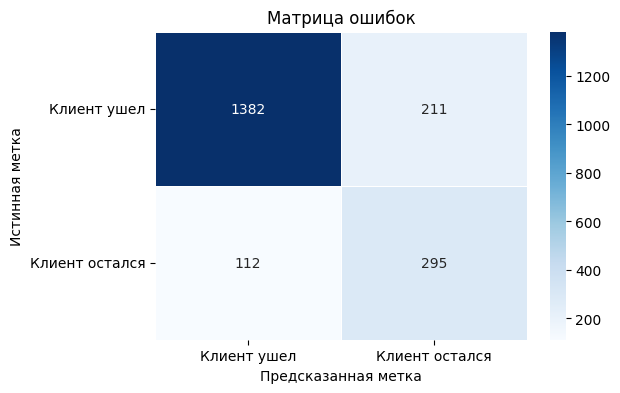


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 500
Глубина деревьева: 4
Скорость обучения: 0.02
Train Accuracy: 0.8403, Test Accuracy: 0.8385
Train F1-score: 0.6477, Test F1-score: 0.6462
1.2


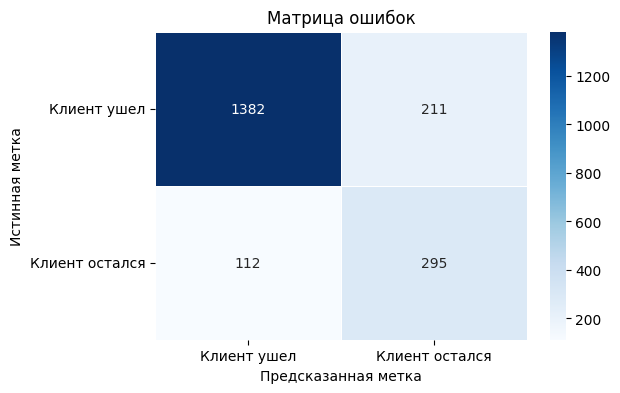


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 500
Глубина деревьева: 4
Скорость обучения: 0.02
Train Accuracy: 0.8403, Test Accuracy: 0.8385
Train F1-score: 0.6477, Test F1-score: 0.6462
1.2


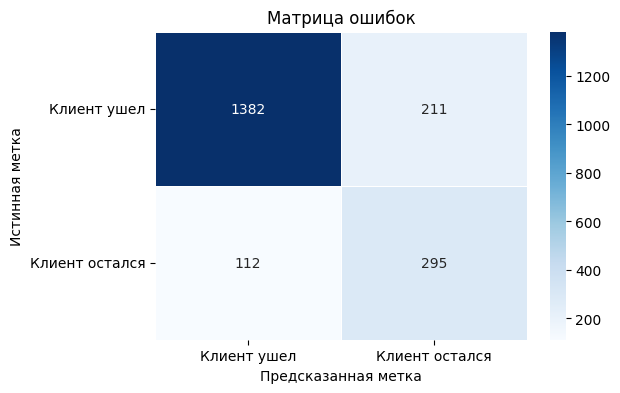


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 500
Глубина деревьева: 4
Скорость обучения: 0.03
Train Accuracy: 0.8464, Test Accuracy: 0.8365
Train F1-score: 0.6589, Test F1-score: 0.6418
1.2


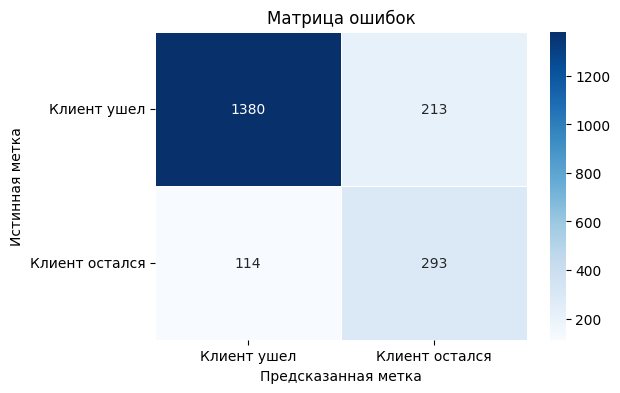


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 4
Скорость обучения: 0.03
Train Accuracy: 0.8464, Test Accuracy: 0.8365
Train F1-score: 0.6589, Test F1-score: 0.6418
1.2


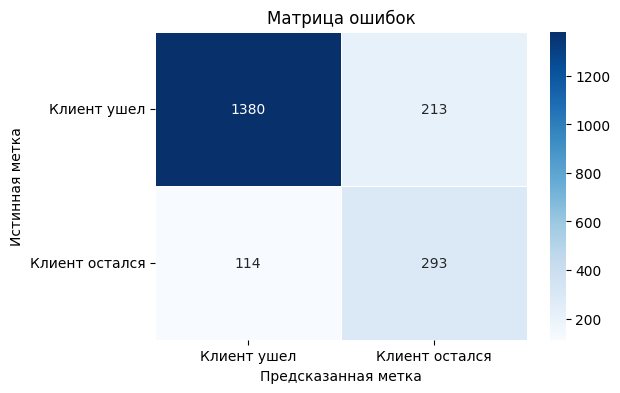


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 4
Скорость обучения: 0.03
Train Accuracy: 0.8464, Test Accuracy: 0.8365
Train F1-score: 0.6589, Test F1-score: 0.6418
1.2


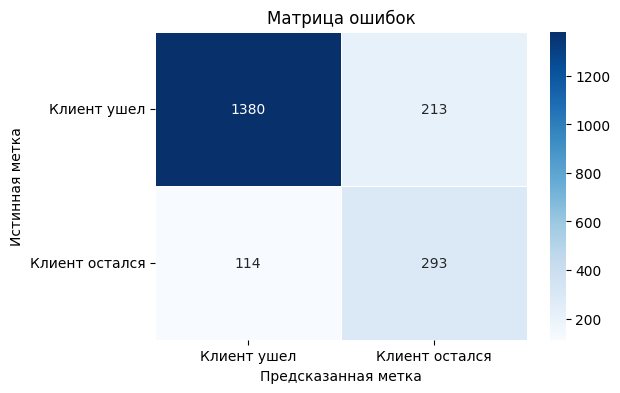


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 5
Скорость обучения: 0.02
Train Accuracy: 0.8431, Test Accuracy: 0.8335
Train F1-score: 0.6536, Test F1-score: 0.6376
1.2


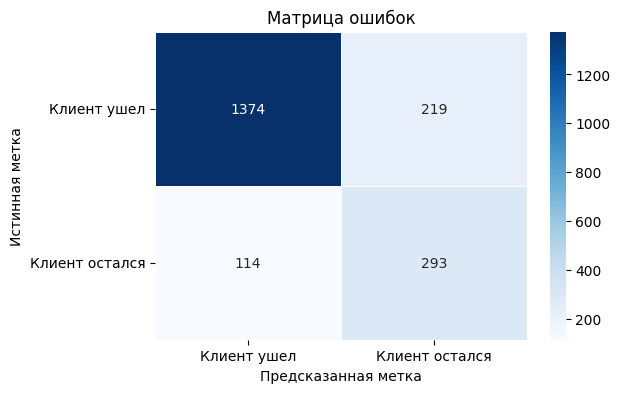


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 5
Скорость обучения: 0.02
Train Accuracy: 0.8431, Test Accuracy: 0.8335
Train F1-score: 0.6536, Test F1-score: 0.6376
1.2


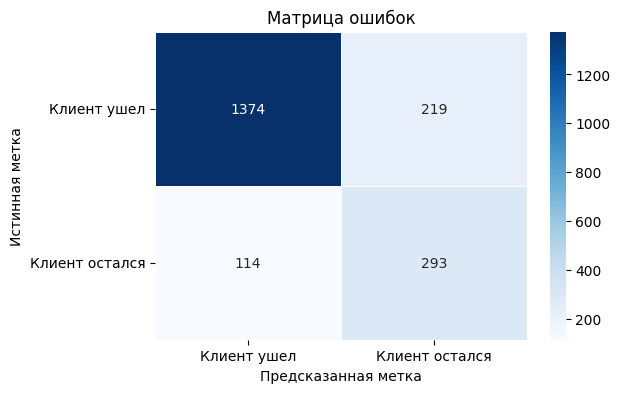


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 5
Скорость обучения: 0.02
Train Accuracy: 0.8431, Test Accuracy: 0.8335
Train F1-score: 0.6536, Test F1-score: 0.6376
1.2


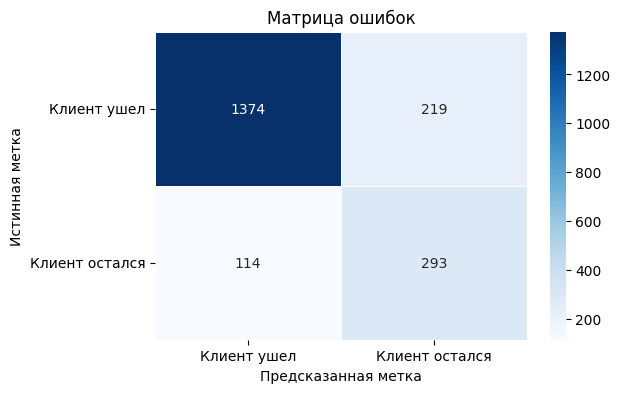


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 7
Скорость обучения: 0.02
Train Accuracy: 0.8591, Test Accuracy: 0.8355
Train F1-score: 0.6876, Test F1-score: 0.6404
1.2


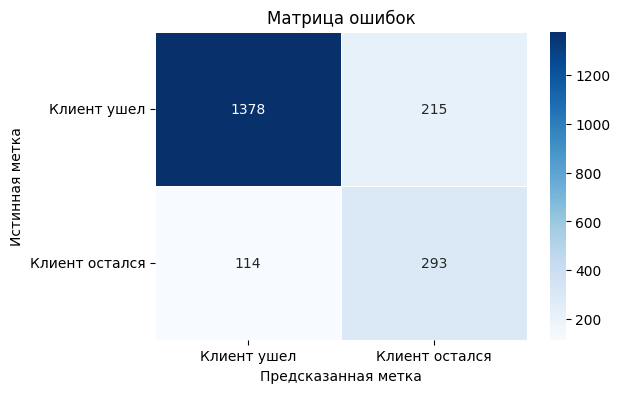


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 7
Скорость обучения: 0.02
Train Accuracy: 0.8591, Test Accuracy: 0.8355
Train F1-score: 0.6876, Test F1-score: 0.6404
1.2


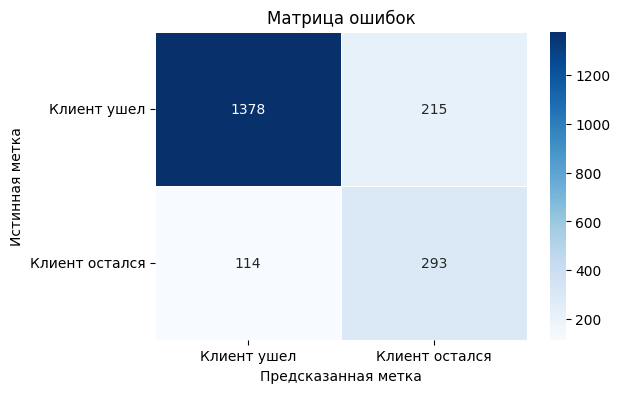


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 7
Скорость обучения: 0.02
Train Accuracy: 0.8591, Test Accuracy: 0.8355
Train F1-score: 0.6876, Test F1-score: 0.6404
1.2


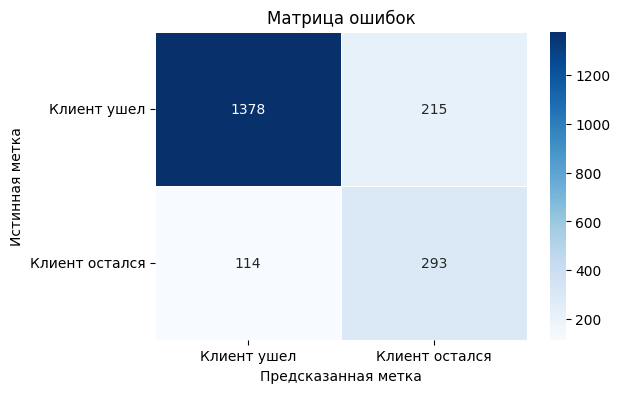


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 7
Скорость обучения: 0.02
Train Accuracy: 0.8514, Test Accuracy: 0.8320
Train F1-score: 0.6798, Test F1-score: 0.6356
1.3


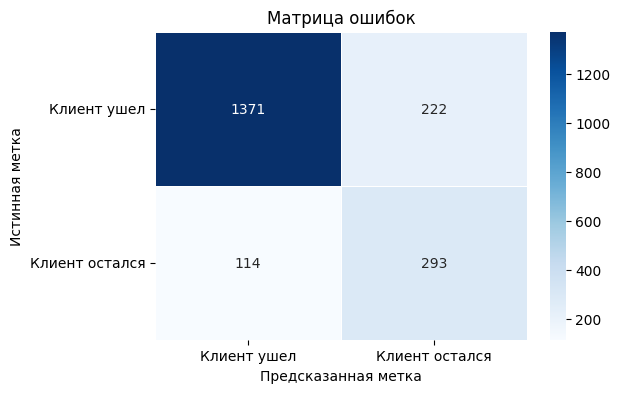


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 7
Скорость обучения: 0.02
Train Accuracy: 0.8514, Test Accuracy: 0.8320
Train F1-score: 0.6798, Test F1-score: 0.6356
1.3


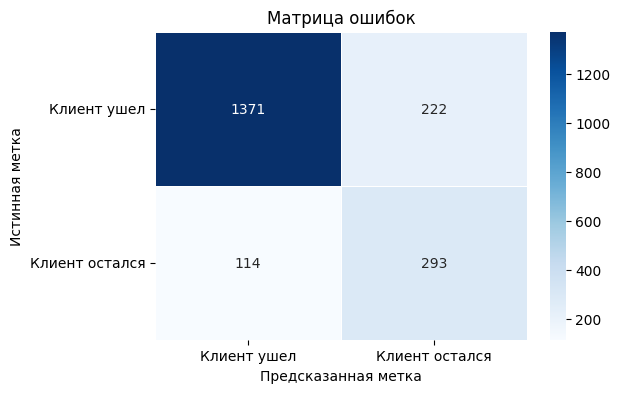


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 500
Глубина деревьева: 7
Скорость обучения: 0.02
Train Accuracy: 0.8514, Test Accuracy: 0.8320
Train F1-score: 0.6798, Test F1-score: 0.6356
1.3


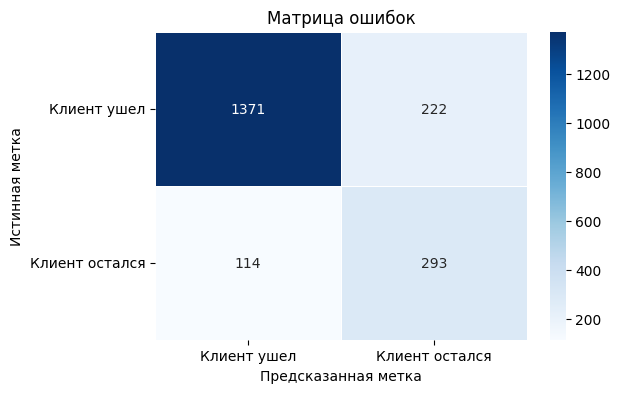


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
600
Количество деревьев: 600
Глубина деревьева: 4
Скорость обучения: 0.02
Train Accuracy: 0.8424, Test Accuracy: 0.8390
Train F1-score: 0.6518, Test F1-score: 0.6485
1.2


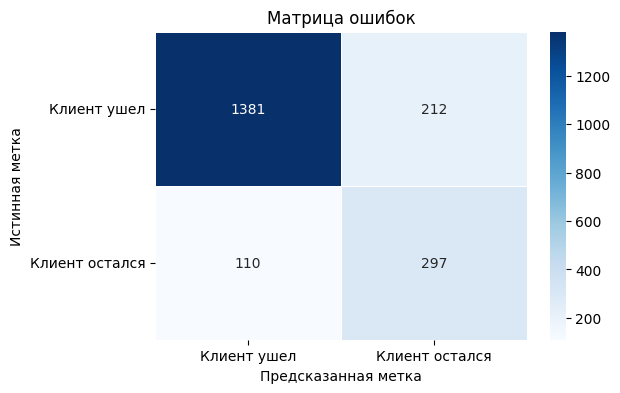


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 600
Глубина деревьева: 4
Скорость обучения: 0.02
Train Accuracy: 0.8424, Test Accuracy: 0.8390
Train F1-score: 0.6518, Test F1-score: 0.6485
1.2


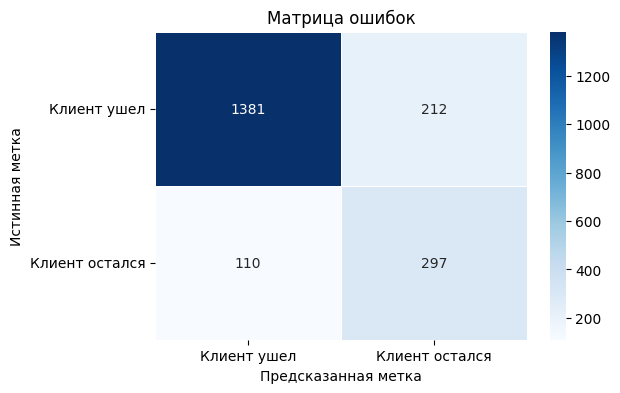


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 600
Глубина деревьева: 4
Скорость обучения: 0.02
Train Accuracy: 0.8424, Test Accuracy: 0.8390
Train F1-score: 0.6518, Test F1-score: 0.6485
1.2


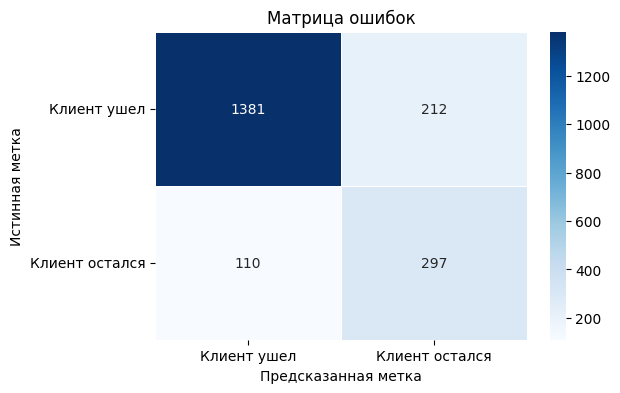


Classification Report:
Class 0 - Precision: F1-score: 0.90, Support: 1593
Class 1 - Precision: F1-score: 0.65, Support: 407
Количество деревьев: 600
Глубина деревьева: 4
Скорость обучения: 0.035
Train Accuracy: 0.8524, Test Accuracy: 0.8340
Train F1-score: 0.6728, Test F1-score: 0.6383
1.2


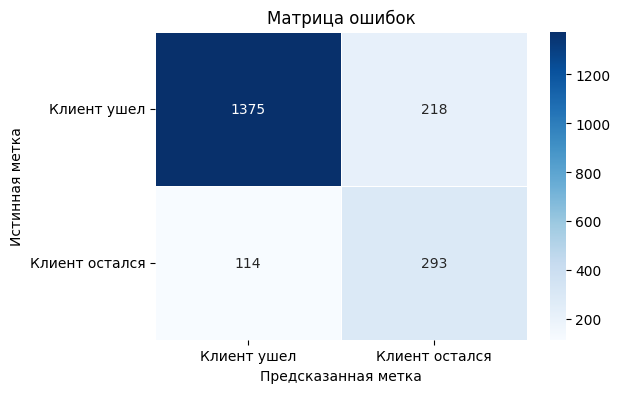


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 600
Глубина деревьева: 4
Скорость обучения: 0.035
Train Accuracy: 0.8524, Test Accuracy: 0.8340
Train F1-score: 0.6728, Test F1-score: 0.6383
1.2


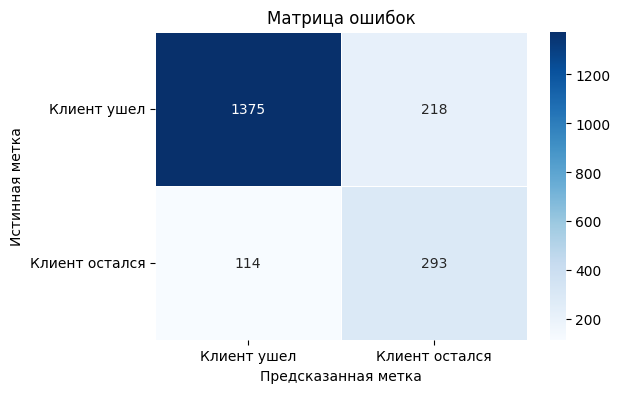


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 600
Глубина деревьева: 4
Скорость обучения: 0.035
Train Accuracy: 0.8524, Test Accuracy: 0.8340
Train F1-score: 0.6728, Test F1-score: 0.6383
1.2


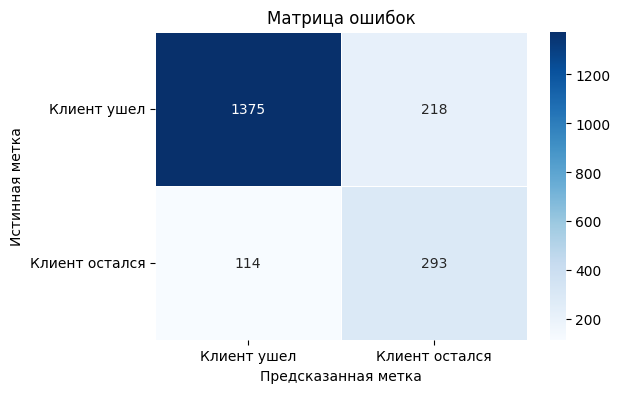


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 600
Глубина деревьева: 7
Скорость обучения: 0.02
Train Accuracy: 0.8595, Test Accuracy: 0.8330
Train F1-score: 0.6965, Test F1-score: 0.6377
1.3


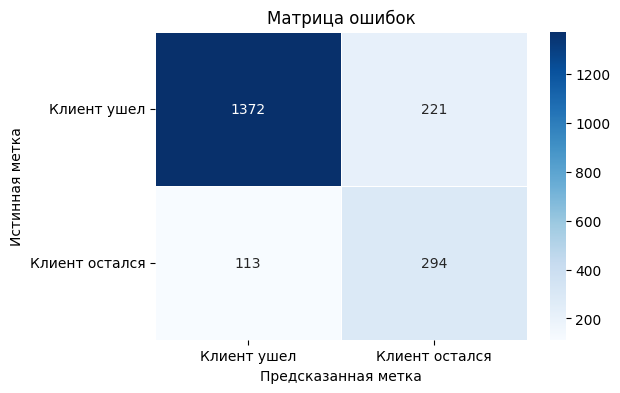


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 600
Глубина деревьева: 7
Скорость обучения: 0.02
Train Accuracy: 0.8595, Test Accuracy: 0.8330
Train F1-score: 0.6965, Test F1-score: 0.6377
1.3


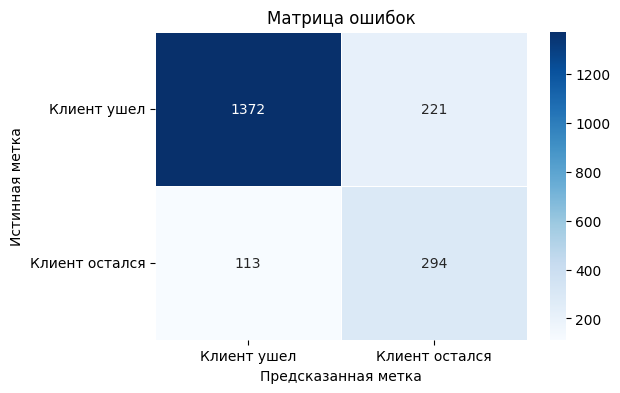


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 600
Глубина деревьева: 7
Скорость обучения: 0.02
Train Accuracy: 0.8595, Test Accuracy: 0.8330
Train F1-score: 0.6965, Test F1-score: 0.6377
1.3


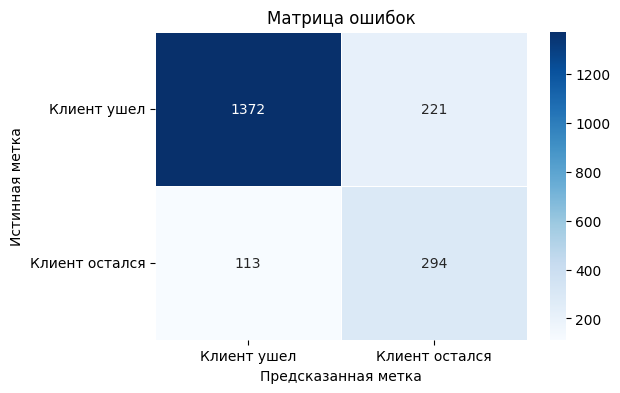


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 600
Глубина деревьева: 7
Скорость обучения: 0.03
Train Accuracy: 0.8808, Test Accuracy: 0.8355
Train F1-score: 0.7392, Test F1-score: 0.6412
1.3


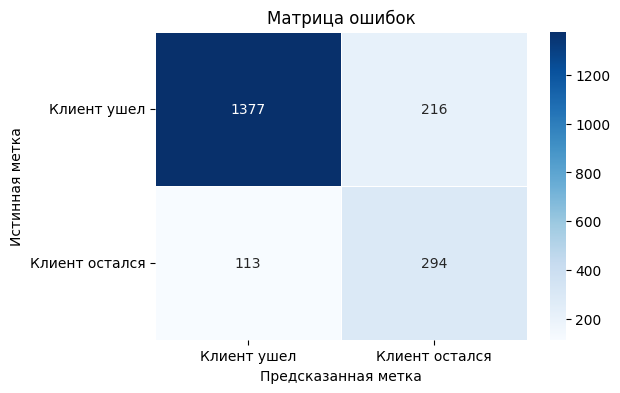


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 600
Глубина деревьева: 7
Скорость обучения: 0.03
Train Accuracy: 0.8808, Test Accuracy: 0.8355
Train F1-score: 0.7392, Test F1-score: 0.6412
1.3


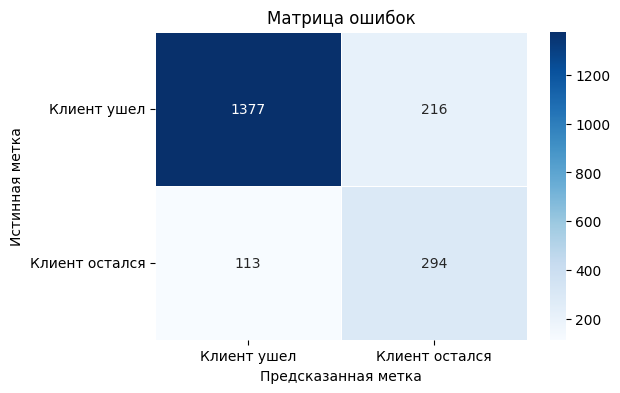


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 600
Глубина деревьева: 7
Скорость обучения: 0.03
Train Accuracy: 0.8808, Test Accuracy: 0.8355
Train F1-score: 0.7392, Test F1-score: 0.6412
1.3


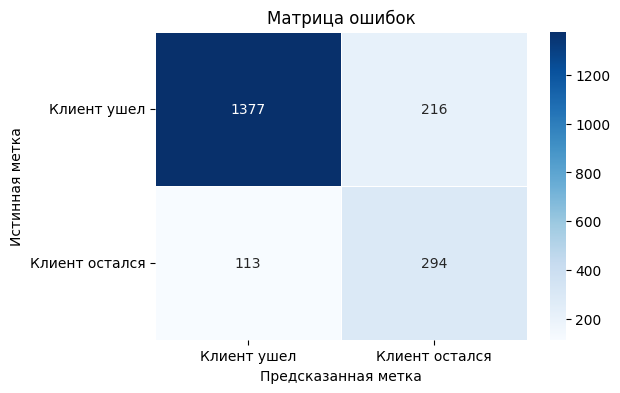


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
700
Количество деревьев: 700
Глубина деревьева: 4
Скорость обучения: 0.02
Train Accuracy: 0.8446, Test Accuracy: 0.8355
Train F1-score: 0.6558, Test F1-score: 0.6404
1.2


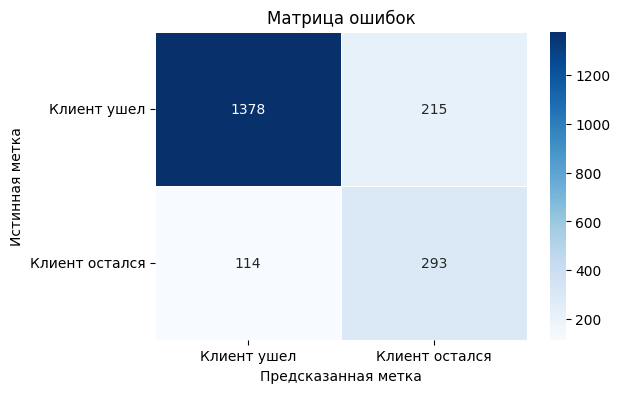


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 700
Глубина деревьева: 4
Скорость обучения: 0.02
Train Accuracy: 0.8446, Test Accuracy: 0.8355
Train F1-score: 0.6558, Test F1-score: 0.6404
1.2


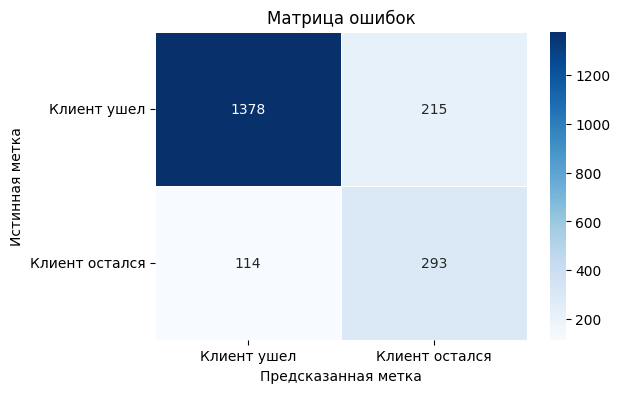


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407
Количество деревьев: 700
Глубина деревьева: 4
Скорость обучения: 0.02
Train Accuracy: 0.8446, Test Accuracy: 0.8355
Train F1-score: 0.6558, Test F1-score: 0.6404
1.2


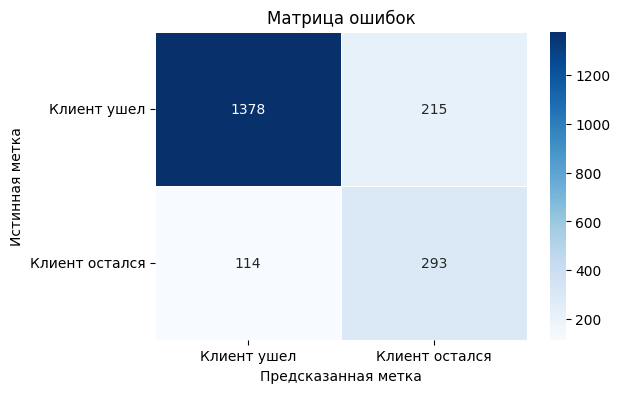


Classification Report:
Class 0 - Precision: F1-score: 0.89, Support: 1593
Class 1 - Precision: F1-score: 0.64, Support: 407


In [ ]:

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Создание и обучение модели с подбором гиперпараметров

learning_rate =[0.01,0.02, 0.03, 0.035, 0.04, 0.05,0.06]
for estimator in range(100,201,100):
  print(estimator)
  for depth in range(3,8):
    for learn_rate in learning_rate:
        for multiplier in [1, 1.1, 1.2,1.3]:
          for l2 in range(4,7):

            model = CatBoostClassifier(
                iterations= estimator,
                learning_rate= learn_rate ,
                depth=depth ,
                cat_features=categorical_features,
                scale_pos_weight=class_weights_dict[1] * multiplier ,
                verbose= False,
                l2_leaf_reg=6,
            )

            model.fit(X_train, y_train)

            # Предсказания
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Вычисление метрик
            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)

            train_f1 = f1_score(y_train, y_train_pred)
            test_f1 = f1_score(y_test, y_test_pred)

            cm_matrix = confusion_matrix(y_test, y_test_pred)
            if cm_matrix[1][0] < 115 and cm_matrix[0][1] < 223:
              print(f'Количество деревьев: {estimator}')
              print(f'Глубина деревьева: {depth}')
              print(f'Скорость обучения: {learn_rate}')
              # Вычисление метрик
              train_accuracy = accuracy_score(y_train, y_train_pred)
              test_accuracy = accuracy_score(y_test, y_test_pred)

              train_f1 = f1_score(y_train, y_train_pred)
              test_f1 = f1_score(y_test, y_test_pred)

              print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
              print(f"Train F1-score: {train_f1:.4f}, Test F1-score: {test_f1:.4f}")
              print(multiplier)
              matrix_error(cm_matrix)
              # Вывод Classification Report без accuracy, macro avg и weighted avg
              report = classification_report(y_test, y_test_pred, digits=4, zero_division=0, output_dict=True)
              # Вычисление метрик

              print("\nClassification Report:")
              print(f"Class 0 - Precision: F1-score: {report['0']['f1-score']:.2f}, Support: {int(report['0']['support'])}")
              print(f"Class 1 - Precision: F1-score: {report['1']['f1-score']:.2f}, Support: {int(report['1']['support'])}")
              # print(f"Class 1 - Precision: {report['1']['precision']:.2f}, Recall: {report['1']['recall']:.2f}, F1-score: {report['1']['f1-score']:.2f}, Support: {int(report['1']['support'])}")

In [6]:
def Mutnes(cd):
  a,b,c,d = cd[0][0],cd[0][1],cd[1][0],cd[1][1]
  print(f'МСС = {(a*d - b*c)/(np.sqrt((a+b) * (a+c) * (d+b) * (c+d)))}')

def matrix_error(cm):

  # Настраиваем отображение
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)

  # Подписываем оси на русском
  plt.xlabel("Предсказанная метка")
  plt.ylabel("Истинная метка")
  plt.title("Матрица ошибок")
  plt.xticks(ticks=[0.5, 1.5], labels=["Клиент ушел", "Клиент остался"])
  plt.yticks(ticks=[0.5, 1.5], labels=["Клиент ушел", "Клиент остался"], rotation=0)

  # Показываем график
  plt.show()


In [ ]:
# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Создание и обучение модели с подбором гиперпараметров
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=5,
    cat_features=categorical_features,
    scale_pos_weight=class_weights_dict[1] * 1.2,
    verbose= False, 
    l2_leaf_reg=6,
)

model.fit(X_train, y_train)

# Предсказания
y_train_pred = (model.predict_proba(X_train)[:, 1] > 0.5).astype(int)
y_test_pred = (model.predict_proba(X_test)[:, 1] > 0.5).astype(int)

# Вычисление метрик
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Train F1-score: {train_f1:.4f}, Test F1-score: {test_f1:.4f}")

# Вывод Classification Report без accuracy, macro avg и weighted avg
report = classification_report(y_test, y_test_pred, digits=4, zero_division=0, output_dict=True)
print(report)
print("\nClassification Report:")
print(f"Class 0 - Precision: F1-score: {report['0']['f1-score']:.2f}, Support: {int(report['0']['support'])}")
print(f"Class 1 - Precision: F1-score: {report['1']['f1-score']:.2f}, Support: {int(report['1']['support'])}")
# print(f"Class 1 - Precision: {report['1']['precision']:.2f}, Recall: {report['1']['recall']:.2f}, F1-score: {report['1']['f1-score']:.2f}, Support: {int(report['1']['support'])}")


# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test, y_test_pred)
matrix_error(cm)
Mutnes(cm)

NameError: name 'train_test_split' is not defined

## Проверки

**Если не использовать весса классов**

* С вычислением веса классов:

  Train Accuracy: 0.8472, Test Accuracy: 0.8465

  Train F1-score: 0.6499, Test F1-score: 0.6523
* Без:

  Train Accuracy: 0.8679, Test Accuracy: 0.8705

  Train F1-score: 0.5998, Test F1-score: 0.6046

Без весов классов модель будет игнорировать несбалансированность классов, что может привести к снижению точности на менее представленном классе. Это мы и можем наблюдать на фоне Test F1-score: **0.6523** против **0.6046** в пользу использования вычисления веса классов. Хоть и Test Accuracy в первой случае ниже: **0.8465** против **0.8705**, в нашем случае F1-оценка — более информативный показатель, чем точность, т.к. наши данные несбалансированы.


**Почему F1-score важен:**
* Точность может быть высокой (например, если класс 0 составляет 90% выборки), но это не всегда указывает на хорошую модель, так как она может просто предсказывать «класс 0» для большинства примеров, пропуская важные случаи (класс 1).
* F1-оценка помогает избежать этой проблемы, поскольку учитывает обе ошибки (ложноположительные и ложноотрицательные).

## Проверка на переобучаемость


1. **Если модель переобучается:**

* Высокая точность на **test**, но низкая на **train**
* F1-score сильно падает на **test** по сравнению с train.
* Модель делает много уверенных, но ошибочных предсказаний.
2. **Если модель недообучена:**

* Точность на **train** и **test** примерно одинаковая, но не высокая.
* F1-score низкий, модель не улавливает паттерны.





Если **train_accuracy** и **train_f1** значительно выше, чем на **test**, модель переобучается.

In [ ]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=4,
    cat_features=categorical_features,
    scale_pos_weight=class_weights_dict[1] * 1.1,
    verbose=200,
    l2_leaf_reg=6,
)




Train Accuracy: 0.8472, Test Accuracy: 0.8465
Train F1-score: 0.6499, Test F1-score: 0.6523

## Проверка фичей

Class distribution:
churn
0    7963
1    2037
Name: count, dtype: int64
Class Weights: {0: 0.6279040562602034, 1: 2.454590083456063}
0:	learn: 0.6825584	total: 3.84ms	remaining: 1.34s
1:	learn: 0.6726013	total: 6.42ms	remaining: 1.12s
2:	learn: 0.6631157	total: 9.11ms	remaining: 1.05s
3:	learn: 0.6535299	total: 11.8ms	remaining: 1.02s
4:	learn: 0.6447918	total: 14.3ms	remaining: 985ms
5:	learn: 0.6366002	total: 16.7ms	remaining: 956ms
6:	learn: 0.6303013	total: 18.9ms	remaining: 928ms
7:	learn: 0.6260798	total: 21.4ms	remaining: 913ms
8:	learn: 0.6192911	total: 23.6ms	remaining: 895ms
9:	learn: 0.6122573	total: 25.9ms	remaining: 880ms
10:	learn: 0.6057197	total: 28.7ms	remaining: 886ms
11:	learn: 0.6018943	total: 30.7ms	remaining: 865ms
12:	learn: 0.5956124	total: 32.6ms	remaining: 845ms
13:	learn: 0.5902331	total: 34.7ms	remaining: 832ms
14:	learn: 0.5860442	total: 36.9ms	remaining: 824ms
15:	learn: 0.5815466	total: 39ms	remaining: 815ms
16:	learn: 0.5775103	total: 41.1ms	remaining: 8

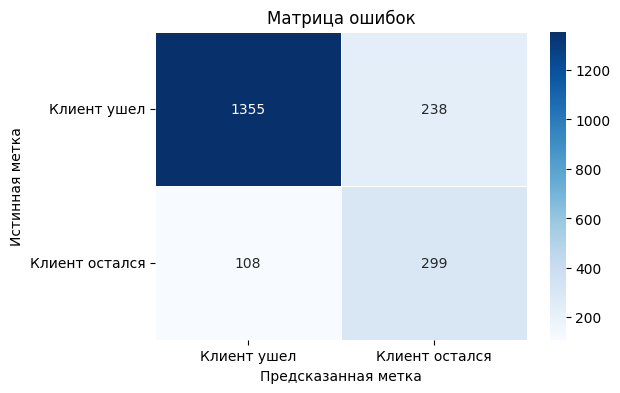

МСС = 0.0)


In [39]:

# Выбираем признаки и целевую переменную
features = ['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
            'products_number', 'active_member', 'estimated_salary']

target = 'churn'

# Разделение на X и y
X = df[features]
y = df[target]


# Определяем категориальные признаки (CatBoost сам их обработает)
categorical_features = ['country', 'gender']

# Проверяем баланс классов
class_counts = y.value_counts()
print("Class distribution:")
print(class_counts)

# Вычисляем веса классов (если данные несбалансированные)
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights_dict)

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# X_test, X_oot, Y_test, Y_oot = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Создание и обучение модели с подбором гиперпараметров
model = CatBoostClassifier(
    iterations=350,
    learning_rate=0.025,
    depth=4,
    cat_features=categorical_features,
    scale_pos_weight=class_weights_dict[1] * 1.3
    
)

model_cat = model.fit(X_train, y_train)

# Предсказания
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Вычисление метрик
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Train F1-score: {train_f1:.4f}, Test F1-score: {test_f1:.4f}")

# Вывод Classification Report без accuracy, macro avg и weighted avg
report = classification_report(y_test, y_test_pred, digits=4, zero_division=0, output_dict=True)

print("\nClassification Report:")
print(f"Class 0 - Precision: F1-score: {report['0']['f1-score']:.2f}, Support: {int(report['0']['support'])}")
print(f"Class 1 - Precision: F1-score: {report['1']['f1-score']:.2f}, Support: {int(report['1']['support'])}")
# print(f"Class 1 - Precision: {report['1']['precision']:.2f}, Recall: {report['1']['recall']:.2f}, F1-score: {report['1']['f1-score']:.2f}, Support: {int(report['1']['support'])}")

cm = confusion_matrix(y_test, y_test_pred)
matrix_error(cm)
Mutnes(cm)


In [ ]:

argList_lgbm2 = fs.backward_selection(features, model_cat, X_train, y_train, X_test, y_test, quality_loss = 0.65)

lgbm_model.fit(x_train[argList_lgbm2], y_train)
probs_test = lgbm_model.predict_proba(x_test[argList_lgbm2])[:, 1]
probs_train = lgbm_model.predict_proba(x_train[argList_lgbm2])[:, 1]

print('Количество признаков в модели = ', len(argList_lgbm2))
print('roc_auc train = ', roc_auc_score(y_train, probs_train),
      'roc_auc test = ', roc_auc_score(y_test, probs_test))

ROC AUC Test initial=  0.8773580976970807


ValueError: 'country' is not in list